In [128]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression


mls = pd.read_csv('c:/Users/sgfis/projects/Capstone_2_resources/MLS_2017_to_2020.csv')

mls.columns = mls.columns.str.lower()
mls.columns = mls.columns.str.replace(' ', '_')

# General EDA

With my data set imported, it's time to do some EDA on the types. Since the goal of this project is to predict residential prices, I need to do sort out residential from non-residential and do some early cleaning

In [129]:
mls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9628 entries, 0 to 9627
Data columns (total 53 columns):
parcel_number                                9628 non-null object
class                                        9628 non-null object
county                                       9628 non-null object
price                                        9627 non-null object
list_date                                    9628 non-null object
list_price                                   9628 non-null object
selling_price                                9627 non-null object
selling_price.1                              0 non-null float64
days_on_market                               9628 non-null int64
days_on_mls                                  9628 non-null int64
closed_date                                  9627 non-null object
date_history_status                          9628 non-null object
price_/_sqft                                 2584 non-null object
list_price_/_sqft                      

In [130]:
mls['class'].value_counts()

RE    6908
AT    2401
CM     174
MF     145
Name: class, dtype: int64

Dropping the columns that have no input values at all

In [131]:
mls_df =  mls.drop(columns = ['selling_price.1', 'addtrentyn', '#_tenants', 
                              '#_floors', 'cap_rate_%', 'condition.1', 'date_leased', 'number_of_acres',
                              'pass_thru_exp/sf_annual', 'price/sqft_annual', 'price/sqft_monthly',
                              'total_#_of_units','net_operating_income'])

mls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9628 entries, 0 to 9627
Data columns (total 40 columns):
parcel_number                                9628 non-null object
class                                        9628 non-null object
county                                       9628 non-null object
price                                        9627 non-null object
list_date                                    9628 non-null object
list_price                                   9628 non-null object
selling_price                                9627 non-null object
days_on_market                               9628 non-null int64
days_on_mls                                  9628 non-null int64
closed_date                                  9627 non-null object
date_history_status                          9628 non-null object
price_/_sqft                                 2584 non-null object
list_price_/_sqft                            6908 non-null object
sold_price/sqft                      

In [132]:
mls_df.head()

,parcel_number,class,county,price,list_date,list_price,selling_price,days_on_market,days_on_mls,closed_date,date_history_status,price_/_sqft,list_price_/_sqft,sold_price/sqft,original_price,date_price_change,how_sold_code,address,city,state,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,listing_type,listing_visibility_type,for_comp_purposes_only_y/n,mls_only_entry_y/n_(no_services_provided),sale/rent,short_sale_y/n,taxes_-_annual,#_of_garage_spaces,garage_y/n,pool_y/n,zoning,bank_owned_y/n,auction
0,06600-012-003,AT,Alachua,"$55,750",11/9/2017,"$59,900","$55,750",33,33,12/12/2017,12/12/2017,$54.95,NaN,$51.15,"$59,900",12/12/2017,CASH,6256 SW 8TH Place,Gainesville,FL,32607,"1,090",1983.0,1.0,2.0,1.0,NaN,Exclusive Right of Sale,MLS Listing,No,No,For Sale,No,$859,NaN,No,NaN,NaN,No,No
1,07240-050-207,AT,Alachua,"$108,000",3/2/2018,"$115,000","$108,000",31,31,4/2/2018,4/10/2018,$98.12,NaN,$92.15,"$115,000",4/10/2018,CASH,4415 SW 34TH Street 207,Gainesville,FL,32608,"1,172",2000.0,2.0,2.0,1.0,NaN,Exclusive Right of Sale,MLS Listing,No,No,For Sale,No,"$1,676",NaN,No,NaN,NaN,No,No
2,13199-010-011,AT,Alachua,"$59,000",4/28/2017,"$63,000","$59,000",88,88,8/3/2017,8/9/2017,$68.63,NaN,$64.27,"$63,000",8/9/2017,CONVENTIONAL,914 SW 8th Avenue 34,Gainesville,FL,32601,918,1969.0,1.0,4.0,1.0,NaN,Exclusive Right of Sale,MLS Listing,No,Yes,For Sale,No,"$1,070",NaN,No,NaN,NaN,No,No
3,06770-151-000,AT,Alachua,"$55,000",1/13/2018,"$56,000","$55,000",41,41,2/23/2018,2/27/2018,$45.68,NaN,$44.86,"$56,000",2/27/2018,CASH,2811 SW Archer Road S-151,Gainesville,FL,32608,"1,226",1985.0,2.0,2.0,0.0,NaN,Exclusive Right of Sale,MLS Listing,No,No,For Sale,No,"$1,022",NaN,No,NaN,NaN,No,No
4,07242-090-007,AT,Alachua,"$105,000",7/6/2019,"$105,000","$105,000",18,18,7/24/2019,7/25/2019,$89.90,NaN,$89.90,"$105,000",7/6/2019,CASH,4411 SW 34th Street 907,Gainesville,FL,32608,"1,168",1985.0,2.0,2.0,1.0,Other,Exclusive Right of Sale,MLS Listing,No,No,For Sale,No,"$1,329",NaN,No,NaN,NaN,No,No


In [133]:
resmls_df = mls_df[mls_df['class'].isin(['AT', 'RE'])]

## Fixing Price and Converting obj to ints

There are a ton of price variables, so it's time to test for redundacy

In [134]:
resmls_df.loc[:,['price_/_sqft','price', 'list_price','list_price_/_sqft', 'original_price', 'selling_price', 'sold_price/sqft']]

,price_/_sqft,price,list_price,list_price_/_sqft,original_price,selling_price,sold_price/sqft
0,$54.95,"$55,750","$59,900",NaN,"$59,900","$55,750",$51.15
1,$98.12,"$108,000","$115,000",NaN,"$115,000","$108,000",$92.15
2,$68.63,"$59,000","$63,000",NaN,"$63,000","$59,000",$64.27
3,$45.68,"$55,000","$56,000",NaN,"$56,000","$55,000",$44.86
4,$89.90,"$105,000","$105,000",NaN,"$105,000","$105,000",$89.90
...,...,...,...,...,...,...,...
9623,NaN,"$451,920","$445,700",$132.65,"$445,700","$451,920",$134.50
9624,NaN,"$339,440","$309,942",$153.44,"$309,942","$339,440",$168.04
9625,NaN,"$359,423","$352,837",$167.22,"$321,000","$359,423",$170.34
9626,NaN,"$332,105","$329,843",$194.03,"$329,843","$332,105",$195.36


I see some redundancy with price / selling_price and list_price / original_price. Since selling_price and list_price are clearer I'll drop price and original_price. I'm also planning on dropping list_price_/_sqft and price_/_sqft as it's hard to tell if they are redundant and are easy to calculate on my own (likely user input incosistencies)

In [135]:
resmls_df.drop(columns = ['price_/_sqft', 'price', 'list_price_/_sqft', 'original_price'], inplace= True)

C:\Users\sgfis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


All of my prices are coming up as objects, likely due to the $. I'll need to strip and convert them to floats or ints before continuing my EDA

In [136]:
# commented out for ease of reading notebook

# for column_name in ["list_price", "selling_price"]:
#     print("These are the problematic values for the variable: {}".format(column_name))
#     for value in resmls_df[column_name]:
#         try:
#             float(value)
#         except:
#             print(value)

These are the problematic values for the variable: list_price
$59,900 
$115,000 
$63,000 
$56,000 
$105,000 
$87,900 
$230,000 
$46,500 
$112,000 
$208,000 
$99,500 
$65,000 
$72,000 
$52,000 
$63,000 
$183,000 
$99,800 
$149,000 
$160,000 
$51,000 
$62,000 
$81,000 
$85,500 
$65,000 
$41,420 
$152,900 
$160,000 
$124,900 
$149,900 
$98,900 
$220,000 
$79,900 
$140,000 
$125,000 
$65,000 
$89,500 
$149,000 
$63,000 
$61,000 
$59,000 
$106,900 
$139,900 
$134,900 
$128,000 
$169,500 
$89,900 
$83,750 
$99,000 
$89,500 
$122,500 
$165,000 
$165,000 
$157,900 
$152,500 
$114,900 
$155,000 
$70,000 
$149,900 
$140,000 
$99,000 
$110,000 
$127,500 
$162,000 
$199,000 
$95,000 
$57,500 
$89,900 
$60,000 
$61,000 
$182,500 
$150,000 
$95,000 
$249,000 
$124,900 
$89,000 
$173,000 
$83,900 
$140,000 
$189,900 
$110,000 
$144,900 
$149,900 
$96,000 
$165,000 
$104,000 
$173,500 
$109,900 
$118,000 
$139,900 
$104,900 
$158,900 
$53,500 
$260,000 
$150,000 
$146,500 
$79,900 
$139,900 
$115,000 

$89,000 
$130,000 
$477,818 
$118,000 
$79,000 
$164,750 
$113,101 
$138,000 
$89,900 
$74,900 
$132,500 
$108,000 
$59,900 
$59,900 
$145,900 
$64,900 
$81,000 
$82,500 
$48,000 
$110,000 
$62,800 
$70,000 
$69,900 
$112,000 
$125,000 
$124,000 
$104,900 
$124,900 
$84,900 
$115,000 
$122,900 
$91,800 
$53,000 
$93,000 
$25,900 
$104,900 
$37,000 
$99,900 
$125,000 
$77,900 
$81,999 
$104,000 
$42,000 
$80,000 
$599,092 
$129,000 
$130,000 
$62,500 
$99,900 
$80,000 
$500,371 
$73,000 
$129,900 
$59,000 
$124,900 
$70,000 
$170,000 
$109,900 
$239,900 
$55,000 
$239,000 
$119,900 
$161,000 
$145,000 
$89,900 
$80,000 
$107,900 
$139,000 
$137,500 
$164,201 
$259,000 
$164,990 
$121,999 
$147,500 
$55,000 
$57,500 
$379,000 
$176,900 
$130,000 
$131,000 
$227,550 
$175,000 
$166,000 
$186,095 
$219,800 
$165,000 
$95,000 
$155,900 
$109,000 
$79,900 
$108,000 
$87,500 
$89,000 
$127,900 
$120,000 
$139,900 
$121,000 
$49,900 
$165,000 
$215,000 
$124,900 
$29,900 
$166,380 
$182,200 
$

$96,900 
$139,900 
$79,500 
$135,000 
$75,900 
$89,900 
$119,900 
$35,000 
$219,900 
$139,900 
$169,900 
$70,900 
$259,900 
$254,900 
$269,800 
$194,900 
$95,000 
$102,900 
$174,900 
$164,900 
$114,900 
$136,900 
$147,900 
$84,900 
$147,900 
$152,900 
$130,900 
$128,900 
$134,900 
$114,900 
$120,000 
$94,900 
$135,000 
$124,900 
$234,900 
$71,900 
$138,900 
$99,500 
$99,900 
$104,900 
$139,900 
$140,999 
$129,900 
$102,900 
$125,000 
$157,500 
$157,550 
$157,000 
$239,900 
$115,000 
$159,900 
$102,000 
$112,900 
$161,999 
$153,900 
$162,000 
$159,000 
$139,900 
$104,900 
$134,900 
$262,900 
$202,900 
$119,000 
$114,900 
$244,900 
$259,900 
$252,900 
$237,900 
$244,900 
$269,000 
$119,900 
$104,900 
$105,000 
$85,000 
$95,900 
$68,900 
$169,900 
$89,000 
$134,900 
$104,900 
$104,000 
$127,900 
$130,000 
$142,000 
$92,000 
$104,900 
$147,900 
$127,900 
$88,500 
$122,900 
$163,900 
$154,900 
$172,900 
$148,900 
$177,000 
$242,900 
$236,900 
$294,000 
$64,900 
$269,900 
$289,900 
$109,900 

$175,000 
$139,900 
$134,000 
$139,900 
$125,000 
$529,900 
$199,900 
$249,900 
$224,400 
$399,000 
$319,000 
$85,000 
$155,000 
$129,500 
$249,900 
$48,500 
$249,000 
$180,000 
$289,900 
$235,000 
$219,900 
$549,900 
$429,900 
$289,900 
$289,900 
$874,000 
$771,500 
$199,900 
$145,000 
$129,000 
$329,900 
$255,000 
$219,900 
$499,000 
$264,900 
$249,900 
$249,900 
$219,900 
$179,000 
$179,900 
$159,900 
$127,900 
$254,999 
$189,000 
$339,000 
$449,000 
$219,900 
$240,000 
$325,000 
$98,000 
$699,000 
$167,000 
$149,900 
$239,900 
$179,900 
$224,900 
$329,000 
$374,900 
$774,900 
$549,000 
$274,999 
$314,000 
$359,895 
$189,900 
$299,900 
$197,900 
$220,000 
$244,900 
$119,900 
$199,900 
$284,900 
$269,000 
$272,999 
$257,900 
$272,000 
$446,205 
$265,000 
$324,500 
$219,999 
$199,900 
$239,900 
$264,900 
$359,900 
$289,000 
$369,673 
$234,900 
$214,900 
$1,700,000 
$399,000 
$138,000 
$249,900 
$379,000 
$417,000 
$297,500 
$129,900 
$174,500 
$115,000 
$153,000 
$106,500 
$199,000 
$

$147,500 
$274,900 
$174,900 
$210,000 
$89,000 
$264,000 
$294,900 
$199,900 
$299,900 
$269,000 
$295,000 
$210,000 
$259,000 
$255,000 
$179,000 
$179,893 
$175,000 
$440,388 
$271,000 
$286,191 
$267,470 
$405,928 
$285,877 
$291,766 
$245,000 
$292,000 
$174,000 
$185,000 
$325,000 
$330,000 
$167,000 
$169,900 
$179,000 
$149,900 
$249,900 
$254,900 
$129,900 
$352,500 
$419,848 
$239,900 
$214,900 
$125,000 
$178,900 
$379,900 
$170,999 
$234,522 
$214,100 
$224,900 
$115,000 
$240,000 
$109,900 
$199,999 
$249,290 
$240,500 
$336,000 
$70,000 
$169,900 
$228,000 
$289,900 
$349,900 
$54,000 
$54,900 
$301,788 
$303,257 
$272,087 
$289,430 
$244,500 
$149,000 
$101,500 
$209,900 
$139,000 
$219,000 
$159,000 
$249,000 
$60,000 
$199,900 
$212,790 
$137,000 
$273,185 
$299,000 
$85,000 
$334,000 
$239,000 
$219,900 
$232,000 
$389,000 
$142,000 
$240,000 
$50,000 
$209,000 
$220,000 
$244,900 
$130,000 
$185,000 
$202,000 
$244,000 
$179,000 
$259,900 
$149,900 
$154,900 
$250,00

$124,900 
$259,900 
$170,000 
$225,000 
$137,900 
$274,900 
$249,707 
$970,000 
$194,000 
$177,000 
$325,000 
$119,900 
$125,000 
$221,500 
$149,900 
$249,900 
$98,500 
$178,500 
$191,000 
$25,000 
$378,000 
$269,999 
$399,900 
$225,000 
$175,000 
$149,900 
$195,707 
$507,365 
$269,900 
$249,000 
$416,235 
$499,798 
$387,000 
$362,421 
$775,520 
$160,000 
$274,900 
$175,000 
$298,000 
$181,000 
$582,036 
$717,781 
$559,958 
$247,900 
$329,900 
$350,000 
$418,500 
$389,000 
$579,000 
$185,000 
$59,900 
$42,000 
$245,000 
$349,707 
$159,000 
$124,000 
$179,900 
$247,000 
$312,900 
$256,000 
$59,900 
$190,000 
$198,000 
$995,000 
$141,900 
$254,900 
$225,000 
$189,000 
$170,000 
$213,000 
$949,707 
$179,000 
$265,000 
$154,900 
$319,000 
$438,815 
$289,000 
$159,900 
$189,900 
$89,900 
$124,000 
$384,000 
$105,000 
$204,500 
$210,000 
$259,707 
$535,470 
$185,000 
$214,500 
$150,000 
$259,900 
$249,900 
$189,900 
$310,000 
$179,000 
$435,000 
$260,000 
$268,707 
$169,900 
$194,707 
$247,7

$90,000 
$82,000 
$105,800 
$124,000 
$124,900 
$187,500 
$219,900 
$258,990 
$329,900 
$139,900 
$149,900 
$734,000 
$235,500 
$196,000 
$250,000 
$292,900 
$189,500 
$189,900 
$291,910 
$355,000 
$225,000 
$519,000 
$265,000 
$230,000 
$259,000 
$198,999 
$212,000 
$499,000 
$106,900 
$339,900 
$329,900 
$289,000 
$240,068 
$354,900 
$207,500 
$293,921 
$247,475 
$189,900 
$229,000 
$68,900 
$40,000 
$75,000 
$315,000 
$69,900 
$690,000 
$299,950 
$465,000 
$319,900 
$229,900 
$199,900 
$115,000 
$279,800 
$227,500 
$352,500 
$298,285 
$266,991 
$253,225 
$109,900 
$234,900 
$259,000 
$210,000 
$298,700 
$178,000 
$399,000 
$450,000 
$324,900 
$589,000 
$560,000 
$859,900 
$334,900 
$369,000 
$385,000 
$347,500 
$276,900 
$355,000 
$504,900 
$109,950 
$187,000 
$148,900 
$239,000 
$377,900 
$62,500 
$244,900 
$349,800 
$169,900 
$268,000 
$259,900 
$264,500 
$285,900 
$305,550 
$288,000 
$229,900 
$634,900 
$649,000 
$110,000 
$639,900 
$499,900 
$279,000 
$224,900 
$575,000 
$165,00

$94,900 
$139,900 
$309,500 
$199,900 
$353,500 
$180,000 
$139,900 
$150,000 
$255,000 
$74,500 
$355,000 
$101,200 
$889,000 
$507,900 
$224,500 
$284,000 
$71,000 
$479,000 
$187,500 
$130,000 
$214,932 
$145,000 
$105,000 
$299,900 
$164,900 
$149,900 
$139,900 
$129,900 
$169,000 
$231,900 
$209,000 
$289,000 
$110,000 
$144,500 
$182,000 
$242,000 
$116,000 
$139,000 
$29,900 
$439,000 
$145,000 
$399,000 
$219,900 
$117,900 
$217,000 
$155,000 
$134,900 
$189,900 
$709,640 
$95,000 
$90,000 
$168,500 
$520,480 
$125,000 
$169,900 
$129,900 
$344,900 
$200,000 
$169,900 
$309,900 
$290,500 
$513,274 
$79,900 
$99,500 
$374,900 
$161,200 
$196,000 
$229,000 
$259,900 
$149,500 
$945,000 
$65,000 
$251,900 
$29,900 
$659,000 
$334,900 
$285,000 
$245,000 
$130,000 
$125,000 
$77,000 
$164,900 
$544,900 
$189,900 
$154,900 
$89,875 
$70,000 
$28,000 
$184,900 
$183,500 
$295,000 
$209,900 
$559,000 
$179,900 
$475,000 
$199,000 
$79,900 
$185,000 
$49,900 
$120,000 
$224,000 
$139,0

$175,000 
$150,000 
$239,000 
$249,900 
$214,900 
$188,000 
$179,900 
$179,500 
$249,900 
$190,000 
$144,000 
$130,000 
$129,900 
$164,500 
$309,900 
$259,900 
$120,000 
$310,000 
$36,000 
$70,000 
$174,900 
$189,900 
$173,500 
$274,916 
$255,000 
$89,000 
$347,900 
$269,000 
$239,900 
$399,999 
$152,000 
$168,900 
$259,000 
$85,000 
$249,900 
$249,950 
$135,000 
$95,000 
$120,000 
$239,900 
$149,900 
$890,106 
$184,900 
$178,000 
$250,000 
$524,500 
$273,800 
$86,000 
$190,000 
$349,900 
$175,000 
$193,500 
$280,000 
$299,500 
$324,000 
$299,900 
$624,208 
$325,000 
$117,300 
$229,000 
$289,000 
$149,500 
$150,000 
$159,900 
$349,900 
$209,900 
$94,800 
$120,000 
$262,500 
$269,900 
$285,000 
$57,500 
$275,000 
$314,900 
$157,000 
$165,900 
$190,000 
$75,000 
$138,900 
$299,900 
$215,000 
$367,000 
$234,000 
$250,000 
$154,900 
$146,500 
$178,000 
$315,000 
$196,000 
$229,900 
$137,500 
$98,000 
$134,500 
$167,000 
$120,000 
$120,000 
$82,500 
$93,500 
$40,000 
$275,000 
$127,000 
$98

$72,000 
$85,500 
$77,000 
$192,500 
$115,000 
$90,000 
$81,900 
$91,000 
$144,500 
$72,000 
$91,500 
$32,000 
$103,900 
$137,000 
$100,000 
$71,000 
$225,250 
$189,900 
$139,500 
$120,000 
$133,200 
$229,000 
$145,000 
$122,000 
$112,500 
$95,250 
$252,900 
$95,000 
$124,500 
$113,500 
$135,000 
$49,000 
$109,900 
$89,500 
$131,000 
$134,900 
$70,000 
$116,000 
$107,500 
$175,500 
$141,500 
$63,500 
$130,000 
$52,000 
$56,000 
$106,220 
$217,000 
$75,000 
$99,000 
$77,000 
$109,900 
$144,900 
$39,000 
$61,000 
$133,000 
$75,500 
$87,500 
$107,000 
$62,500 
$60,000 
$98,500 
$92,000 
$84,000 
$73,000 
$61,200 
$58,000 
$142,000 
$115,400 
$175,000 
$150,000 
$194,000 
$85,500 
$136,000 
$141,000 
$126,500 
$133,000 
$249,000 
$139,000 
$70,000 
$70,750 
$152,000 
$125,000 
$80,000 
$134,900 
$127,500 
$133,000 
$93,000 
$140,000 
$129,900 
$179,000 
$185,000 
$130,000 
$100,000 
$55,000 
$199,000 
$83,000 
$158,000 
$123,000 
$126,500 
$55,000 
$56,000 
$76,000 
$110,000 
$130,500 
$14

$160,000 
$149,000 
$171,000 
$147,000 
$171,225 
$240,500 
$220,000 
$294,000 
$56,000 
$269,900 
$288,000 
$107,900 
$141,500 
$32,334 
$155,000 
$110,000 
$119,000 
$140,000 
$139,000 
$50,000 
$125,000 
$114,000 
$150,000 
$145,000 
$129,500 
$375,000 
$135,000 
$175,000 
$155,000 
$269,000 
$46,300 
$290,000 
$140,000 
$465,000 
$180,000 
$166,000 
$208,000 
$173,500 
$175,000 
$189,900 
$282,500 
$320,000 
$190,000 
$252,000 
$199,000 
$260,000 
$245,000 
$225,500 
$256,500 
$374,000 
$345,000 
$225,000 
$296,900 
$195,000 
$145,000 
$350,000 
$207,000 
$182,000 
$190,000 
$313,500 
$129,000 
$179,500 
$220,000 
$220,000 
$206,000 
$390,000 
$218,000 
$175,000 
$245,000 
$225,000 
$105,000 
$380,000 
$167,000 
$159,900 
$100,000 
$268,000 
$159,000 
$132,000 
$169,500 
$227,000 
$365,000 
$375,000 
$175,000 
$381,000 
$279,000 
$157,000 
$175,000 
$180,000 
$110,000 
$260,000 
$245,000 
$316,000 
$175,000 
$200,000 
$150,000 
$315,000 
$265,000 
$185,000 
$295,000 
$242,500 
$290

$220,000 
$376,900 
$235,000 
$228,500 
$525,000 
$160,000 
$269,000 
$245,000 
$355,000 
$250,000 
$144,000 
$92,500 
$289,000 
$266,000 
$211,998 
$210,000 
$193,000 
$120,000 
$91,600 
$149,900 
$112,500 
$130,000 
$181,000 
$664,000 
$269,900 
$159,000 
$229,000 
$465,000 
$228,500 
$405,000 
$345,000 
$490,000 
$640,000 
$161,933 
$239,000 
$235,500 
$146,000 
$275,000 
$161,000 
$290,000 
$249,900 
$199,900 
$215,000 
$278,600 
$999,900 
$595,000 
$135,000 
$490,000 
$221,600 
$179,000 
$511,000 
$459,000 
$448,000 
$169,900 
$231,000 
$135,000 
$152,000 
$180,000 
$135,000 
$165,500 
$190,000 
$134,000 
$221,000 
$267,000 
$197,500 
$535,000 
$469,000 
$232,000 
$516,500 
$269,500 
$171,000 
$110,000 
$230,000 
$75,000 
$236,000 
$754,000 
$232,000 
$230,000 
$690,000 
$406,000 
$789,000 
$224,625 
$230,000 
$290,000 
$138,000 
$180,000 
$132,500 
$293,000 
$215,000 
$622,000 
$243,500 
$205,000 
$187,500 
$158,000 
$150,000 
$355,000 
$216,788 
$167,400 
$80,000 
$222,500 
$179

$120,000 
$82,500 
$173,000 
$250,000 
$72,500 
$183,000 
$153,000 
$285,000 
$189,000 
$180,000 
$249,900 
$151,000 
$535,000 
$310,000 
$283,000 
$239,900 
$80,000 
$18,000 
$399,000 
$290,000 
$165,000 
$192,500 
$271,450 
$310,000 
$150,000 
$229,999 
$275,000 
$260,000 
$193,500 
$315,000 
$174,000 
$275,000 
$200,000 
$65,000 
$182,900 
$336,250 
$152,000 
$215,000 
$105,500 
$125,000 
$223,900 
$165,500 
$170,000 
$130,000 
$135,000 
$193,750 
$79,000 
$110,000 
$678,000 
$71,000 
$200,000 
$197,000 
$232,000 
$92,000 
$435,000 
$93,000 
$251,200 
$334,000 
$51,000 
$164,000 
$265,000 
$29,900 
$64,000 
$95,000 
$230,000 
$195,000 
$183,500 
$175,000 
$265,000 
$290,000 
$241,000 
$138,500 
$235,000 
$373,000 
$175,000 
$133,000 
$142,000 
$177,400 
$585,000 
$230,000 
$159,900 
$153,000 
$125,000 
$175,000 
$285,000 
$168,000 
$107,500 
$152,000 
$115,000 
$232,000 
$315,000 
$216,000 
$91,500 
$500,000 
$135,000 
$232,000 
$132,000 
$265,000 
$222,000 
$164,900 
$168,900 
$155

$110,000 
$293,000 
$48,200 
$325,000 
$290,000 
$244,700 
$220,500 
$210,000 
$330,000 
$331,000 
$327,000 
$132,000 
$200,000 
$144,200 
$240,500 
$55,000 
$231,000 
$420,000 
$127,500 
$299,000 
$366,000 
$610,000 
$125,000 
$64,500 
$185,000 
$423,000 
$204,350 
$295,000 
$296,500 
$327,000 
$210,000 
$513,405 
$689,504 
$577,298 
$501,720 
$451,243 
$408,258 
$575,624 
$45,000 
$169,900 
$495,735 
$212,500 
$185,000 
$192,000 
$215,000 
$147,000 
$149,000 
$183,000 
$195,101 
$542,500 
$197,500 
$571,000 
$245,000 
$260,000 
$260,000 
$330,000 
$171,000 
$145,000 
$192,000 
$388,000 
$212,000 
$135,000 
$355,000 
$73,449 
$202,500 
$210,000 
$166,500 
$230,000 
$249,900 
$10,000 
$375,000 
$48,369 
$249,900 
$55,000 
$288,000 
$136,000 
$599,000 
$232,000 
$171,000 
$300,000 
$130,000 
$178,000 
$208,000 
$279,000 
$240,000 
$314,900 
$390,000 
$195,000 
$340,000 
$355,000 
$248,000 
$56,007 
$53,954 
$40,000 
$289,764 
$240,000 
$190,000 
$140,000 
$150,000 
$178,500 
$37,200 
$1

$160,400 
$259,000 
$285,900 
$198,000 
$276,950 
$274,680 
$241,650 
$234,000 
$288,600 
$275,000 
$170,010 
$134,000 
$290,000 
$238,000 
$225,000 
$289,000 
$412,000 
$241,900 
$215,000 
$200,000 
$263,000 
$250,000 
$238,500 
$526,800 
$207,000 
$222,000 
$191,000 
$227,166 
$230,000 
$128,000 
$278,000 
$224,900 
$230,000 
$200,000 
$405,000 
$345,816 
$344,475 
$260,795 
$254,875 
$316,571 
$269,379 
$250,603 
$262,213 
$142,000 
$228,000 
$50,000 
$50,000 
$258,500 
$260,000 
$312,000 
$459,000 
$790,000 
$337,000 
$235,000 
$435,000 
$410,000 
$189,900 
$160,000 
$173,500 
$166,500 
$195,000 
$175,000 
$350,000 
$178,000 
$165,000 
$256,000 
$423,000 
$295,000 
$355,000 
$417,000 
$983,000 
$450,000 
$120,000 
$122,000 
$340,000 
$450,000 
$460,000 
$193,000 
$292,500 
$195,000 
$590,000 
$374,000 
$310,000 
$153,500 
$225,000 
$211,000 
$342,257 
$272,058 
$274,821 
$270,556 
$232,635 
$879,500 
$298,000 
$180,000 
$202,400 
$377,000 
$189,900 
$48,500 
$235,000 
$63,000 
$355

$302,500 
$87,500 
$198,100 
$268,000 
$300,000 
$180,000 
$176,500 
$295,000 
$166,000 
$275,000 
$297,199 
$87,000 
$305,813 
$289,232 
$200,000 
$295,346 
$106,500 
$188,000 
$292,040 
$329,513 
$364,150 
$338,755 
$306,685 
$421,197 
$47,000 
$210,000 
$130,000 
$269,170 
$276,438 
$264,958 
$242,000 
$51,000 
$220,000 
$302,494 
$243,800 
$385,155 
$595,000 
$288,703 
$409,474 
$293,879 
$456,797 
$184,000 
$385,000 
$357,000 
$320,000 
$500,000 
$228,000 
$127,000 
$308,786 
$302,022 
$313,797 
$342,295 
$345,653 
$144,000 
$274,114 
$261,000 
$259,500 
$440,000 
$351,445 
$307,412 
$389,518 
$98,000 
$146,000 
$364,416 
$125,000 
$400,000 
$174,000 
$255,000 
$148,000 
$230,000 
$292,481 
$388,308 
$333,502 
$289,782 
$313,116 
$368,282 
$340,175 
$181,900 
$279,614 
$255,060 
$429,490 
$123,000 
$215,000 
$699,000 
$120,000 
$189,000 
$240,000 
$516,000 
$180,900 
$165,000 
$329,481 
$328,464 
$60,000 
$125,000 
$235,000 
$227,500 
$135,000 
$250,185 
$326,695 
$351,788 
$385,8

In [137]:
df_obj = resmls_df.select_dtypes(['object'])

resmls_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip('$'))

resmls_df = resmls_df.apply(lambda x: x.str.replace(',','') if x.dtype == "object" else x)


C:\Users\sgfis\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [138]:
resmls_df[['list_price', 'selling_price', 'sold_price/sqft','sfheatcool']] = resmls_df[['list_price', 'selling_price', 'sold_price/sqft','sfheatcool']].apply(pd.to_numeric)

In [139]:
resmls_df['list_sqft_price'] = (resmls_df['list_price'] / resmls_df['sfheatcool']).round(2)

## Dropping Columns cont: Redundant and/or Useless

In [140]:
resmls_df.columns

Index(['parcel_number', 'class', 'county', 'list_date', 'list_price',
       'selling_price', 'days_on_market', 'days_on_mls', 'closed_date',
       'date_history_status', 'sold_price/sqft', 'date_price_change',
       'how_sold_code', 'address', 'city', 'state', 'zip_code', 'sfheatcool',
       'year_built', 'baths', 'bedrooms', 'half-baths', 'condition',
       'listing_type', 'listing_visibility_type', 'for_comp_purposes_only_y/n',
       'mls_only_entry_y/n_(no_services_provided)', 'sale/rent',
       'short_sale_y/n', 'taxes_-_annual', '#_of_garage_spaces', 'garage_y/n',
       'pool_y/n', 'zoning', 'bank_owned_y/n', 'auction', 'list_sqft_price'],
      dtype='object')

In [141]:
resmls_df['for_comp_purposes_only_y/n'].value_counts()

No     9194
Yes     113
Name: for_comp_purposes_only_y/n, dtype: int64

Going to drop columns that don't add any value to my analysis or are occuring as redundancies.

Sale/rent is useless since I pulled only residential sales data and no rental data. Listing type is also useless as it does little to impact sale price and only refers to the relationship between agent and seller. Listing visibility type only has one value and can be dropped for ease of analysis as well.

For comp purposes also doesn't mean much in this case since it's usually used for commercial properties that are sold off the mls. For residential, it means the house was sold by an agent but not on the mls. This won't impact sales price and can be dropped as a column.

As we can see below, the vast majority of MLS ONLY ENTRIES are 'No' and that input doesn't impact sales price much, it's just a reflection of marketing preference for the seller. The column can be dropped.

Annual Taxes is something else I can drop, as that has no bearing on sales price and because property taxes aren't a fixed  value. Taxes get adjusted everytime there is a sale, and in Florida a homeowner can cap tax increases over the years. To put it simply, buyers shouldn't expect to pay the same taxes as the seller.
b
Auction as whole will be dropped, but first I plan on dropping the rows that indicate the property was sold in an auction since that will inevitably produce outliers that are not consistent with the rest of our sold data.

List date / sold date / days on mls / date history status / date price change can all be dropped as days on market provides all the information I need. Since list date and sold date can provide helpful insight later, I'm going to avoid dropping in place and plan on dropping them after other EDA has been completed.

In [142]:
resmls_df.drop(columns = ['sale/rent','days_on_mls', 'date_price_change', 'date_history_status', 
                          'listing_type', 'listing_visibility_type', 'for_comp_purposes_only_y/n', 
                          'mls_only_entry_y/n_(no_services_provided)', 'taxes_-_annual'], inplace = True)

In [143]:
# residential_df = resmls_df.drop(columns = ['list_date', 'closed_date'])

In [144]:
resmls_df['auction'].value_counts()

No     9247
Yes      59
Name: auction, dtype: int64

In [145]:
resmls_df = resmls_df[resmls_df['auction'] == 'No']

In [146]:
resmls_df = resmls_df.drop(columns = 'auction')

In [147]:
resmls_df.columns

Index(['parcel_number', 'class', 'county', 'list_date', 'list_price',
       'selling_price', 'days_on_market', 'closed_date', 'sold_price/sqft',
       'how_sold_code', 'address', 'city', 'state', 'zip_code', 'sfheatcool',
       'year_built', 'baths', 'bedrooms', 'half-baths', 'condition',
       'short_sale_y/n', '#_of_garage_spaces', 'garage_y/n', 'pool_y/n',
       'zoning', 'bank_owned_y/n', 'list_sqft_price'],
      dtype='object')

## EDA on Nulls

In [148]:
resmls_df.isna().mean().sort_values(ascending=False)*100

zoning                92.592192
#_of_garage_spaces    39.591219
condition             38.023143
pool_y/n              25.813777
how_sold_code          0.032443
selling_price          0.010814
year_built             0.010814
closed_date            0.010814
list_sqft_price        0.000000
address                0.000000
class                  0.000000
county                 0.000000
list_date              0.000000
list_price             0.000000
days_on_market         0.000000
sold_price/sqft        0.000000
zip_code               0.000000
city                   0.000000
state                  0.000000
bank_owned_y/n         0.000000
sfheatcool             0.000000
baths                  0.000000
bedrooms               0.000000
half-baths             0.000000
short_sale_y/n         0.000000
garage_y/n             0.000000
parcel_number          0.000000
dtype: float64

In [149]:
resmls_df.sort_values(by = 'zoning', ascending = False)

,parcel_number,class,county,list_date,list_price,selling_price,days_on_market,closed_date,sold_price/sqft,how_sold_code,address,city,state,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,zoning,bank_owned_y/n,list_sqft_price
5568,13745-000-000,RE,Alachua,9/6/2018,139000,125000.0,29,10/5/2018,132.98,CASH,809 NW 4TH Avenue,Gainesville,FL,32601,940,1930.0,1.0,2.0,0.0,Handyman Special,No,NaN,No,No,UMU-1,No,147.87
2776,15518-000-000,RE,Alachua,10/4/2019,409000,375000.0,53,11/26/2019,177.81,CASH,949 SW 13th Street,Gainesville,FL,32601,2109,1938.0,2.0,4.0,0.0,Other,No,NaN,No,No,U9,No,193.93
4962,13705-000-000,RE,Alachua,10/2/2019,200000,151000.0,55,11/26/2019,128.40,CASH,901 NW 3RD Avenue,Gainesville,FL,32601,1176,1935.0,2.0,3.0,0.0,Other,No,NaN,No,No,U6,No,170.07
5015,13707-000-000,RE,Alachua,10/2/2019,200000,151000.0,55,11/26/2019,131.88,CASH,120 NW 9TH Street,Gainesville,FL,32601,1145,1930.0,1.0,3.0,0.0,Other,No,NaN,No,No,U6,No,174.67
3061,12167-000-000,RE,Alachua,4/11/2019,295000,254000.0,113,8/2/2019,137.74,CONVENTIONAL,405 SE 8th Street,Gainesville,FL,32601,1844,1965.0,2.0,3.0,0.0,Other,No,2,Yes,No,U3,No,159.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9623,07027-002-037,RE,Alachua,10/12/2016,445700,451920.0,239,6/8/2017,134.50,CASH,7406 SW 65th Place,Gainesville,FL,32608,3360,2017.0,4.0,6.0,1.0,New Construction,No,3,Yes,No,NaN,No,132.65
9624,07027-002-061,RE,Alachua,2/8/2019,309942,339440.0,203,8/30/2019,168.04,VA,7485 SW 65th Place,Gainesville,FL,32608,2020,2019.0,2.0,4.0,1.0,Under Construction,No,2,Yes,No,NaN,No,153.44
9625,07027-002-052,RE,Alachua,8/14/2017,352837,359423.0,333,7/13/2018,170.34,CONVENTIONAL,6581 SW 74th Drive,Gainesville,FL,32608,2110,2018.0,3.0,4.0,0.0,New Construction,No,2,Yes,No,NaN,No,167.22
9626,07027-002-073,RE,Alachua,10/16/2018,329843,332105.0,248,6/21/2019,195.36,CONVENTIONAL,7404 SW 66th Lane,Gainesville,FL,32608,1700,2018.0,2.0,3.0,0.0,Under Construction,No,2,Yes,No,NaN,No,194.03


In [150]:
resmls_df.zoning.value_counts()

RSF-1                     165
PD                        122
R-1A                       90
RSF-2                      69
RSF-3                      44
R-E Residential Estate     23
RE-1aaabb                  21
R-1                        19
A                          17
PUD                        17
A-1                        12
R-1b                       11
RMF-5                      11
RE                         10
RSF-12                     10
RC                          6
AGR                         4
R-1C                        4
R-1c                        3
RSF-4                       3
PUD-1                       3
R-1B                        3
R-2                         3
U2                          2
U6                          2
RH-1                        2
R-3                         2
AG                          1
R1-C                        1
ESA-2                       1
U9                          1
RSF-7                       1
UMU-1                       1
U3        

From my own domain knowledge I can conclude that zoning isn't as important in residential valuation as it is for commercial. The only case it would be is if a house was zoned for a non-residential use case and was sold for a higher value (such as u6 or u9 zoning) which would would have the potential to create an outlier.

As seen in the above table, the "handy man special" UMU1 zoned property, which translates as a house in poor shape, was sold for a high price per squarefoot for cash. Also of note are the two U6 properties which were sold on he same date for the same amount - this indicates a portfolio sale of multiple properties and would be an outlier in my data set. These rows can be safely dropped from my data set.

In [151]:
resi_df = resmls_df.drop(resmls_df[(resmls_df['zoning'] == 'UMU-1') | (resmls_df['zoning'] == 'U9') 
                | (resmls_df['zoning'] == 'U6') | (resmls_df['zoning'] == 'U3') | (resmls_df['zoning'] == 'U2')].index)

In [152]:
resid_df = resi_df.drop(columns = 'zoning')

 '# of garage spaces' is an interesting column with nulls since there is a second column with a categorical garage y/n that has no nulls associated with it. It should be a matter of determining if the nulls have a pattern with the garage y/n column and replacing the null if so.

In [153]:
resid_df[resid_df['#_of_garage_spaces'].isnull()].head(100)

,parcel_number,class,county,list_date,list_price,selling_price,days_on_market,closed_date,sold_price/sqft,how_sold_code,address,city,state,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n,list_sqft_price
0,06600-012-003,AT,Alachua,11/9/2017,59900,55750.0,33,12/12/2017,51.15,CASH,6256 SW 8TH Place,Gainesville,FL,32607,1090,1983.0,1.0,2.0,1.0,NaN,No,NaN,No,NaN,No,54.95
1,07240-050-207,AT,Alachua,3/2/2018,115000,108000.0,31,4/2/2018,92.15,CASH,4415 SW 34TH Street 207,Gainesville,FL,32608,1172,2000.0,2.0,2.0,1.0,NaN,No,NaN,No,NaN,No,98.12
2,13199-010-011,AT,Alachua,4/28/2017,63000,59000.0,88,8/3/2017,64.27,CONVENTIONAL,914 SW 8th Avenue 34,Gainesville,FL,32601,918,1969.0,1.0,4.0,1.0,NaN,No,NaN,No,NaN,No,68.63
3,06770-151-000,AT,Alachua,1/13/2018,56000,55000.0,41,2/23/2018,44.86,CASH,2811 SW Archer Road S-151,Gainesville,FL,32608,1226,1985.0,2.0,2.0,0.0,NaN,No,NaN,No,NaN,No,45.68
4,07242-090-007,AT,Alachua,7/6/2019,105000,105000.0,18,7/24/2019,89.90,CASH,4411 SW 34th Street 907,Gainesville,FL,32608,1168,1985.0,2.0,2.0,1.0,Other,No,NaN,No,NaN,No,89.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,06655-115-804,AT,Alachua,3/3/2018,53900,65000.0,11,3/14/2018,64.81,CASH,6519 W NEWBERRY Road 804,Gainesville,FL,32605,1003,1972.0,2.0,2.0,0.0,Other,No,NaN,No,NaN,No,53.74
121,07294-110-003,AT,Alachua,6/10/2019,92500,83000.0,59,8/8/2019,83.00,OTHER,3905 SW 26TH Terrace C,Gainesville,FL,32608,1000,1980.0,1.0,2.0,1.0,Other,No,NaN,No,NaN,No,92.50
122,07294-214-001,AT,Alachua,5/16/2019,75000,72500.0,97,8/21/2019,73.83,CASH,4015 SW 26TH Drive A,Gainesville,FL,32608,982,1981.0,1.0,2.0,1.0,Other,No,NaN,No,NaN,No,76.37
123,07332-201-019,AT,Alachua,6/4/2019,61000,55000.0,132,10/14/2019,100.36,CASH,2490 SW 14 Drive 19,Gainesville,FL,32608,548,1979.0,1.0,1.0,0.0,Other,No,NaN,No,NaN,No,111.31


In [154]:
resid_df.loc[resid_df['garage_y/n'].eq('No'), '#_of_garage_spaces'] = 0

In [155]:
resid_df.isna().mean()

parcel_number         0.000000
class                 0.000000
county                0.000000
list_date             0.000000
list_price            0.000000
selling_price         0.000108
days_on_market        0.000000
closed_date           0.000108
sold_price/sqft       0.000000
how_sold_code         0.000325
address               0.000000
city                  0.000000
state                 0.000000
zip_code              0.000000
sfheatcool            0.000000
year_built            0.000108
baths                 0.000000
bedrooms              0.000000
half-baths            0.000000
condition             0.380519
short_sale_y/n        0.000000
#_of_garage_spaces    0.000758
garage_y/n            0.000000
pool_y/n              0.258333
bank_owned_y/n        0.000000
list_sqft_price       0.000000
dtype: float64

That took out most of the missing values for # garage spaces, the remaining ones look to be user input error. I feel comfortable dropping these 7 rows.

In [156]:
resid_df[resid_df['#_of_garage_spaces'].isnull()]

,parcel_number,class,county,list_date,list_price,selling_price,days_on_market,closed_date,sold_price/sqft,how_sold_code,address,city,state,zip_code,sfheatcool,year_built,baths,bedrooms,half-baths,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n,list_sqft_price
3092,06326-010-035,RE,Alachua,1/29/2019,262000,239000.0,130,8/1/2019,106.03,CONVENTIONAL,1514 NW 89th Terrace,Gainesville,FL,32606,2254,1997.0,2.0,4.0,0.0,Other,No,NaN,Yes,No,No,116.24
3096,04321-301-010,RE,Alachua,3/6/2019,215000,205000.0,121,7/19/2019,135.49,CONVENTIONAL,1108 NW 120th Way,Gainesville,FL,32606,1513,2005.0,2.0,3.0,0.0,Other,No,NaN,Yes,No,No,142.10
3195,10848-020-127,RE,Alachua,12/13/2016,115000,110000.0,85,3/28/2017,70.38,CONVENTIONAL,1108 NE 21st Street,Gainesville,FL,32641,1563,2005.0,2.0,3.0,0.0,NaN,Yes,NaN,Yes,No,No,73.58
3203,07098-100-057,RE,Alachua,12/15/2018,324900,310000.0,124,4/18/2019,123.41,CASH,7371 SW 84th Drive,Gainesville,FL,32608,2512,2005.0,2.0,4.0,0.0,Other,No,NaN,Yes,No,No,129.34
3263,6113010015,RE,Alachua,1/3/2017,114900,110000.0,135,5/18/2017,81.30,CASH,3526 NW 53rd Terrace,Gainesville,FL,32606,1353,1984.0,2.0,3.0,0.0,NaN,No,NaN,Yes,No,Yes,84.92
5077,06230-002-104,RE,Alachua,9/14/2018,194900,193000.0,42,10/26/2018,136.69,NaN,3559 NW 87th Terrace,Gainesville,FL,32606,1412,1996.0,2.0,3.0,0.0,Other,No,NaN,Yes,No,No,138.03
5088,06394-010-000,RE,Alachua,8/14/2019,164900,150000.0,37,9/20/2019,76.14,CASH,4119 NW 13th Avenue,Gainesville,FL,32605,1970,1958.0,3.0,4.0,0.0,Other,No,NaN,Yes,Yes,No,83.71


In [157]:
reside_df = resid_df.loc[~resid_df['#_of_garage_spaces'].isnull()]

In [158]:
reside_df.isna().mean().sort_values(ascending=False)*100

condition             38.059136
pool_y/n              25.852919
how_sold_code          0.021661
selling_price          0.010831
year_built             0.010831
closed_date            0.010831
list_sqft_price        0.000000
address                0.000000
class                  0.000000
county                 0.000000
list_date              0.000000
list_price             0.000000
days_on_market         0.000000
sold_price/sqft        0.000000
state                  0.000000
city                   0.000000
bank_owned_y/n         0.000000
zip_code               0.000000
sfheatcool             0.000000
baths                  0.000000
bedrooms               0.000000
half-baths             0.000000
short_sale_y/n         0.000000
#_of_garage_spaces     0.000000
garage_y/n             0.000000
parcel_number          0.000000
dtype: float64

In [159]:
reside_df['condition'].value_counts()

Other                 4828
New Construction       664
Handyman Special       131
Under Construction      96
Name: condition, dtype: int64

In [160]:
reside_df['condition'].fillna('Other', inplace=True)

C:\Users\sgfis\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [161]:
reside_df['pool_y/n'].value_counts()

No     5711
Yes    1135
Name: pool_y/n, dtype: int64

In [162]:
reside_df['pool_y/n'].fillna('No', inplace = True)

In [163]:
reside_df['pool_y/n'].value_counts()

No     8098
Yes    1135
Name: pool_y/n, dtype: int64

In [164]:
pd.crosstab(reside_df['pool_y/n'], reside_df['class'])

class,AT,RE
pool_y/n,,
No,2387,5711
Yes,0,1135


## Lower % Nulls

Since the lower % NaNs represent such a small portion of the dataframe, I feel fine with dropping those rows

In [165]:
resident_df = reside_df.dropna()

## MISC EDA

### Gainesville Zip Codes

In [166]:
resident_df['zip_code'].value_counts()

32608         2696
32605         1552
32607         1247
32606         1110
32653          898
              ... 
32641-9316       1
32608-9409       1
32606-5872       1
32608-2562       1
32605-2550       1
Name: zip_code, Length: 293, dtype: int64

There's some inconsistency with zipcode input, so I plan on dropping the dash and remaining four digits following it for zipcodes that are 10 characters long

In [167]:
resident_df['zip_code'] = resident_df['zip_code'].str.split('-').str[0]

C:\Users\sgfis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
resident_df['zip_code'].value_counts()

32608    2766
32605    1613
32607    1289
32606    1167
32653     930
32609     546
32601     517
32641     275
32603     101
32669       8
32615       5
32635       2
32697       1
30024       1
99999       1
32654       1
35605       1
32618       1
32553       1
32604       1
32667       1
32657       1
37607       1
Name: zip_code, dtype: int64

There are a lot of zipcodes here, and not all of them are of my target area. Some research shows that the below zipcodes are within Gainesville, FL.

In [169]:
gainesville_zips = [32601, 32602, 32603, 32604, 32605, 32606, 32607, 32608, 32609, 32610, 32611,32612, 32641, 32653, 32635]

resident_df['zip_code'] = resident_df['zip_code'].astype(int)

resident_df = resident_df.loc[resident_df['zip_code'].isin(gainesville_zips), :]


C:\Users\sgfis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
resident_df['zip_code'].value_counts()

32608    2766
32605    1613
32607    1289
32606    1167
32653     930
32609     546
32601     517
32641     275
32603     101
32635       2
32604       1
Name: zip_code, dtype: int64

## An Unexpected Merge

While performing general EDA I began to realize I didn't have as many feature details as I would expect from the MLS (collective real estate agents database / listing service). There seemed to be only general listing information and no actual property description data. I also felt underwhelmed by the lack of distinguishing features  - I felt like my primary features were squarefeet, bedrooms, pool, and garage spaces. There are a lot more than these features that should impact house prices so I revisited the MLS database and during my exploration I discovered a whole set of property details specific the the RE class of properties.

I downloaded the .csv and plan to merge. Since this information is exclusive to the RE class, I will have to drop the AT class (condo's & apartments) which will make this a considerably more targeted analysis and thus likely more accurate.

In [171]:
mls2 = pd.read_csv('c:/Users/sgfis/downloads/mls_update.csv')

mls2.columns = mls2.columns.str.lower()
mls2.columns = mls2.columns.str.replace(' ', '_')

In [172]:
mls2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6908 entries, 0 to 6907
Data columns (total 74 columns):
parcel_number                                6908 non-null object
class                                        6908 non-null object
county                                       6908 non-null object
price                                        6907 non-null object
list_date                                    6908 non-null object
list_price                                   6908 non-null object
selling_price                                6907 non-null object
selling_price.1                              0 non-null float64
days_on_market                               6908 non-null int64
days_on_mls                                  6908 non-null int64
closed_date                                  6907 non-null object
date_history_status                          6908 non-null object
price_/_sqft                                 0 non-null float64
list_price_/_sqft                        

In [173]:
redundant_columns = ['class', 'county', 'price', 'list_date', 'list_price',
       'selling_price', 'selling_price.1', 'days_on_market', 'days_on_mls',
        'date_history_status', 'price_/_sqft',
       'list_price_/_sqft', 'sold_price/sqft', 'original_price',
       'date_price_change', 'how_sold_code', 'city', 'state',
       'zip_code', 'sfheatcool', 'year_built', 'baths', 'bedrooms',
       'half-baths', 'condition', 'listing_type', 'listing_visibility_type',
       'addtrentyn', '#_tenants', '#_floors', 'cap_rate_%', 'condition.1',
       'date_leased', 'for_comp_purposes_only_y/n',
       'mls_only_entry_y/n_(no_services_provided)', 'number_of_acres',
       'pass_thru_exp/sf_annual', 'price/sqft_annual', 'price/sqft_monthly',
       'sale/rent', 'short_sale_y/n', 'taxes_-_annual', 'total_#_of_units',
       '#_of_garage_spaces', 'garage_y/n', 'net_operating_income', 'pool_y/n',
       'zoning', 'bank_owned_y/n', 'auction']

mls2 = mls2.drop(columns = redundant_columns)

In [174]:
mls2.isna().mean().sort_values(ascending=False)*100

open_house_y/n            100.000000
attachment_count           93.905617
neighborhood_amenities     43.500290
dining_area                41.372322
total_sqft_under_roof      28.807180
waterfront_y/n              0.043428
bathroom_features           0.043428
outbuilding_features        0.028952
closed_date                 0.014476
terms                       0.014476
style                       0.014476
construction_type           0.014476
address                     0.000000
range                       0.000000
roof                        0.000000
exterior_finish             0.000000
parcel_size_(acres)         0.000000
appliances/equipment        0.000000
fencing                     0.000000
floors                      0.000000
interior_layout             0.000000
lot_info                    0.000000
geocode_quality             0.000000
parcel_number               0.000000
dtype: float64

In [175]:
re_mls2 = mls2.drop(columns = ['open_house_y/n', 'attachment_count', 'neighborhood_amenities', 'geocode_quality', 'range'])

In [176]:
residential1 = resident_df[resident_df['class'] == 'RE']

In [177]:
combined_df =  pd.merge(re_mls2, residential1, how = 'inner', on = ['parcel_number', 'address', 'closed_date'])

## Exploring new categorical features

Alot of these descriptive features from the merged data set suffer from unique inputs (or variety of inputs) such as bathroom features. I decided to write a function that creates dummy variables by splitting the strings at commas in order to retain a higher accuracy for my linear regression model. I execute this function later in the feature engineering portion of the notebook.

In [178]:
counts_bath = combined_df['bathroom_features'].value_counts() 

__Note__: I initially wrote the following function to deal with the one off values shown in these descriptive property inputs. After some iterative EDA and model testing, I realized that using a single label for all these one off inputs wasn't providing a lot of insight into collective features for the houses.

In [179]:
# def wrangle_inputs(column_name, n, new_value):
    
#     new_column_name = column_name + '_truncated'
    
#     counts = combined_df[column_name].value_counts() 

#     most_common = counts[:n].index
   
#     combined_df[new_column_name] = combined_df[column_name]

#     combined_df.loc[~(combined_df[column_name].isin(most_common)),[new_column_name]] = new_value
    
#     return combined_df[new_column_name].value_counts()

In [180]:
combined_df['lot_info'].value_counts()

Rectangular-shaped                                                        1272
Other                                                                      566
Square-shaped                                                              485
Wooded Lot                                                                 445
Corner Lot                                                                 423
                                                                          ... 
Corner Lot, Mostly Cleared/Grass, Rectangular-shaped, Other, Sidewalks       1
Corner Lot, Pasture on Property, Rectangular-shaped                          1
Cul-de-sac, Wooded Lot, Other, Sidewalks, Pie-shaped                         1
Cul-de-sac, Golf Course, Other                                               1
Irregular, Other, Sidewalks                                                  1
Name: lot_info, Length: 249, dtype: int64

In [181]:
combined_df['terms'].value_counts()

Cash, Conventional, FHA, VA                                                      1797
Cash, Conventional                                                                755
Cash, Conventional, FHA, Title Ins Provided, VA                                   439
Cash, Conventional, FHA                                                           247
Other                                                                             216
                                                                                 ... 
Cash, FHA, Other, Sold As Is, VA                                                    1
Cash, Conventional, FHA, Title Ins Not Provided, Title Ins Provided, USDA, VA       1
Cash, FHA, Sold As Is, USDA, VA                                                     1
Conventional, May Pay Closing Costs, Other, Title Ins Provided, VA                  1
Conventional, FHA, Title Ins Provided, USDA, VA                                     1
Name: terms, Length: 209, dtype: int64

In [182]:
combined_df['interior_layout'].value_counts()

Living Room                                                                                                              162
Other                                                                                                                    148
Foyer, Great Room, Laundry/Utility Room, Master Downstairs                                                               128
Laundry/Utility Room                                                                                                     127
Laundry/Utility Room, Living Room                                                                                        118
                                                                                                                        ... 
Den/Ofc (Not Inc in Bd #), Foyer, Great Room, In-Law Suite, Laundry/Utility Room, Master Downstairs, Florida/Sun Room      1
Foyer, Great Room, Living Room, Pantry, Storage Area                                                                       1


In [183]:
combined_df['floors'].value_counts()

Carpet, Tile                                          1115
Carpet, Tile, Wood - Hardwood                          969
Carpet, Tile, Wood - Laminate                          484
Tile, Wood - Hardwood                                  399
Tile                                                   319
                                                      ... 
Parquet, Vinyl, None                                     1
No Carpeting, Parquet, Tile, Wood - Hardwood, None       1
Parquet, Wood - Hardwood, Other                          1
Concrete - Finished, Tile, Vinyl                         1
Carpet, Tile, Vinyl, Wood - Laminate, Other              1
Name: floors, Length: 314, dtype: int64

In [184]:
combined_df['style'].value_counts()

Ranch                                                        1633
Contemporary                                                 1415
Traditional                                                   785
Craftsman                                                     408
Other                                                         296
                                                             ... 
Modern, Ranch, Vintage                                          1
Mediterranean, Vintage                                          1
2 Story, Contemporary, Mid-Century Modern, Ranch, Vintage       1
Courtyard, Vintage                                              1
Craftsman, Ranch, Traditional                                   1
Name: style, Length: 217, dtype: int64

In [185]:
combined_df['outbuilding_features'].value_counts()

None                                                                 4534
Storage Shed                                                          981
Other                                                                 521
Workshop                                                              102
Storage Shed, Workshop                                                 81
                                                                     ... 
Bathroom, Pole Barn, Storage Shed, Workshop                             1
5+ Stall Barns, Power, Tack Room, Water                                 1
Storage Shed, Water, Workshop                                           1
Storage Shed, Water, Power 220                                          1
Pole Barn, Power, Storage Shed, Water, Workshop, Other, Power 220       1
Name: outbuilding_features, Length: 99, dtype: int64

In [186]:
combined_df['fencing'].value_counts()

Wood                                                    1620
None                                                    1560
Chain Link                                               592
Other                                                    377
Privacy, Wood                                            350
                                                        ... 
Cross, Wood                                                1
Board (Horse), Complete Perimeter, Mixed Type, Other       1
Chain Link, Partial, Wood, Other                           1
Chain Link, Cross, Wood                                    1
Complete Perimeter, Vinyl                                  1
Name: fencing, Length: 188, dtype: int64

In [187]:
combined_df['appliances/equipment'].value_counts()

None                                                                                                                                215
Cooktop - Electric, Dishwasher, Disposal, Microwave, Oven - Electric, Refrigerator                                                  148
Dishwasher, Oven/Stove, Refrigerator                                                                                                126
Cooktop - Electric, Dishwasher, Disposal, Dryer, Microwave, Oven - Electric, Refrigerator, Washer                                   123
Cooktop - Electric, Dishwasher, Oven - Electric, Refrigerator                                                                       112
                                                                                                                                   ... 
Alarm System, Cooktop - Gas, Dishwasher, Disposal, Dryer, Oven - Double, Oven - Electric, Refrigerator, Washer                        1
Alarm System, Cooktop - Electric, Dishwasher, Di

In [188]:
combined_df['dining_area'].value_counts()

combined_df['dining_area'].fillna('Other', inplace = True)

In [189]:
combined_df['exterior_finish'].value_counts()

Hardiboard/Concr Siding                                   1828
Other                                                      769
Wood                                                       561
Concrete Block                                             424
Conventional Stucco                                        312
                                                          ... 
Board and Batten, Hardiboard/Concr Siding, Wood, Other       1
Deco Brick/Stone, T-111, Concrete Block                      1
Aluminum, Other, Vinyl                                       1
T-111, Wood, Brick                                           1
Brick Veneer, Deco Brick/Stone, Wood                         1
Name: exterior_finish, Length: 185, dtype: int64

In [190]:
combined_df['construction_type'].value_counts()

Frame                                                               2277
Concrete Block                                                      1124
Foundation-Slab, Frame                                              1099
Foundation-Slab                                                      405
Concrete Block, Foundation-Slab                                      196
                                                                    ... 
Foundation-Stilt                                                       1
CB/Frame Front, Foundation-Crawlsp/Piers, Foundation-Slab, Other       1
Frame, Metal/Steel, Other                                              1
CB/Frame Front, Foundation-Crawlsp/Piers, Foundation-Slab              1
Brick, Concrete Block, Foundation-Stilt                                1
Name: construction_type, Length: 98, dtype: int64

In [191]:
combined_df['roof'].value_counts()

Shingle                          5756
Metal                             411
Other                             105
Rolled                             48
Shingle - Asbestos                 33
Flat                               27
Metal, Shingle                     19
Rolled, Shingle                    16
Flat, Shingle                      15
Shingle, Other                     11
Rock or Gravel                     10
Asbestos                           10
Tile                                9
Metal, Rolled                       7
Flat, Other                         5
Flat, Rolled                        5
Shingle, Tile                       5
Metal, Other                        4
Flat, Tile                          3
Rolled, Other                       3
Shingle, Rock or Gravel             3
Flat, Rock or Gravel                2
Other, Rock or Gravel               2
Metal, Rolled, Shingle              2
Shingle, Shingle - Asbestos         2
Tile, Rock or Gravel                1
Flat, Metal,

### Nulls Revisited

Total squarefeet under roof represents the largest null amount. An easy conclusion to make here is that in the instance where those are null, they are likely equal to the heated/cooled squarefeet

In [192]:
combined_df.isna().mean().sort_values(ascending=False)*100

total_sqft_under_roof    27.612626
construction_type         0.015323
style                     0.015323
list_sqft_price           0.000000
outbuilding_features      0.000000
parcel_size_(acres)       0.000000
waterfront_y/n            0.000000
lot_info                  0.000000
terms                     0.000000
interior_layout           0.000000
floors                    0.000000
fencing                   0.000000
bank_owned_y/n            0.000000
appliances/equipment      0.000000
bathroom_features         0.000000
dining_area               0.000000
exterior_finish           0.000000
roof                      0.000000
address                   0.000000
closed_date               0.000000
class                     0.000000
county                    0.000000
list_date                 0.000000
list_price                0.000000
pool_y/n                  0.000000
garage_y/n                0.000000
#_of_garage_spaces        0.000000
short_sale_y/n            0.000000
condition           

In [193]:
combined_df['total_sqft_under_roof'].fillna(combined_df['sfheatcool'], inplace = True)

In [194]:
combined_df = combined_df.dropna()

### Revisiting Redundant Columns & General Housekeeping

Looking at my data set further, I decided to drop features that either dont add any clear information on property value (from a numeric or categorical stand point) or are specifically reflective of the sales process.

At this point, without geocoding and subjective input on regionality, address information doesn't provide insightful information and can be dropped.

In [195]:
cleaning = ['closed_date', 'address', 'class', 'county', 'list_date', 'sold_price/sqft', 'city', 'state', 'list_sqft_price', 'total_sqft_under_roof', 'zip_code', 'days_on_market', 'how_sold_code']

real_estate = combined_df.drop(columns = cleaning)

In [196]:
real_estate['parcel_number'] = real_estate['parcel_number'].str.replace(' ', '')

In [197]:
real_estate.columns

Index(['parcel_number', 'roof', 'construction_type', 'exterior_finish',
       'dining_area', 'bathroom_features', 'appliances/equipment', 'fencing',
       'outbuilding_features', 'style', 'floors', 'interior_layout', 'terms',
       'lot_info', 'waterfront_y/n', 'parcel_size_(acres)', 'list_price',
       'selling_price', 'sfheatcool', 'year_built', 'baths', 'bedrooms',
       'half-baths', 'condition', 'short_sale_y/n', '#_of_garage_spaces',
       'garage_y/n', 'pool_y/n', 'bank_owned_y/n'],
      dtype='object')

In [198]:
real_estate['parcel_size_(acres)'] = real_estate['parcel_size_(acres)'].str.replace(',', '')

In [199]:
real_estate['parcel_size_(acres)'] = real_estate['parcel_size_(acres)'].apply(pd.to_numeric)

## Outlier Time!

### Categorical Detection

In [200]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6525 entries, 0 to 6525
Data columns (total 29 columns):
parcel_number           6525 non-null object
roof                    6525 non-null object
construction_type       6525 non-null object
exterior_finish         6525 non-null object
dining_area             6525 non-null object
bathroom_features       6525 non-null object
appliances/equipment    6525 non-null object
fencing                 6525 non-null object
outbuilding_features    6525 non-null object
style                   6525 non-null object
floors                  6525 non-null object
interior_layout         6525 non-null object
terms                   6525 non-null object
lot_info                6525 non-null object
waterfront_y/n          6525 non-null object
parcel_size_(acres)     6525 non-null float64
list_price              6525 non-null int64
selling_price           6525 non-null float64
sfheatcool              6525 non-null int64
year_built              6525 non-null 

In [201]:
# pd.set_option('display.max_columns', 50)
real_estate.describe(include=[np.object])

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,waterfront_y/n,condition,short_sale_y/n,#_of_garage_spaces,garage_y/n,pool_y/n,bank_owned_y/n
count,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525,6525
unique,6214,38,98,185,81,1880,1800,188,99,217,314,1967,209,249,2,4,2,5,2,2,3
top,06014-024-057,Shingle,Frame,Hardiboard/Concr Siding,Other,Tub/Shower Combo,None,Wood,None,Ranch,"Carpet, Tile",Living Room,"Cash, Conventional, FHA, VA",Rectangular-shaped,No,Other,No,2,Yes,No,No
freq,4,5755,2277,1827,3097,433,215,1620,4533,1633,1114,162,1797,1272,6403,5780,6488,3791,4822,5428,6270


The descriptive statistics give insights to potential outlier rows. Bank owned properties typically are foreclosures, and much like auctions they are not representative of a typical transaction. The same applies for a short sale. Waterfront also represents an outlier since the overwhelming majority of properties are not waterfront. I plan on dropping properties that are short sold, bank owned, and on the waterfront. I'll keep how sold code as that could provide useful insights later.

In [202]:
real_estate['bank_owned_y/n'].value_counts()

No             6270
Yes             153
Undisclosed     102
Name: bank_owned_y/n, dtype: int64

In [203]:
real_estate = real_estate[real_estate['bank_owned_y/n'] == 'No']

In [204]:
real_estate['short_sale_y/n'].value_counts()

No     6235
Yes      35
Name: short_sale_y/n, dtype: int64

In [205]:
real_estate = real_estate[real_estate['short_sale_y/n'] == 'No']

In [206]:
real_estate =  real_estate[real_estate['waterfront_y/n'] == 'No']

In [207]:
real_estate = real_estate.drop(columns = ['short_sale_y/n','bank_owned_y/n', 'waterfront_y/n' ])

### Continuous Outliers

In [208]:
real_estate.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths
count,6114,6114,6114,6114,6114,6114,6114,6114
mean,1.72485,276477,270064,1958.34,1986.68,2.20821,3.3721,0.179097
std,87.6226,175826,170812,822.637,31.8192,0.712344,0.829136,0.404233
min,0,17000,16000,500,201,0,0,0
25%,0.19,170000,169500,1399,1972,2,3,0
50%,0.26,239900,235000,1780,1989,2,3,0
75%,0.4,324900,315000,2318.75,2004,2,4,0
max,6848,1.85e+06,1.803e+06,10285,2340,8,33,3


That works for the categorical, however it's hard to get an eyeball on the outliers present in the continous variables.

NOTE: I know bathrooms and bedrooms aren't continuous variables, but I've placed them here since they are numeric categorical variables.

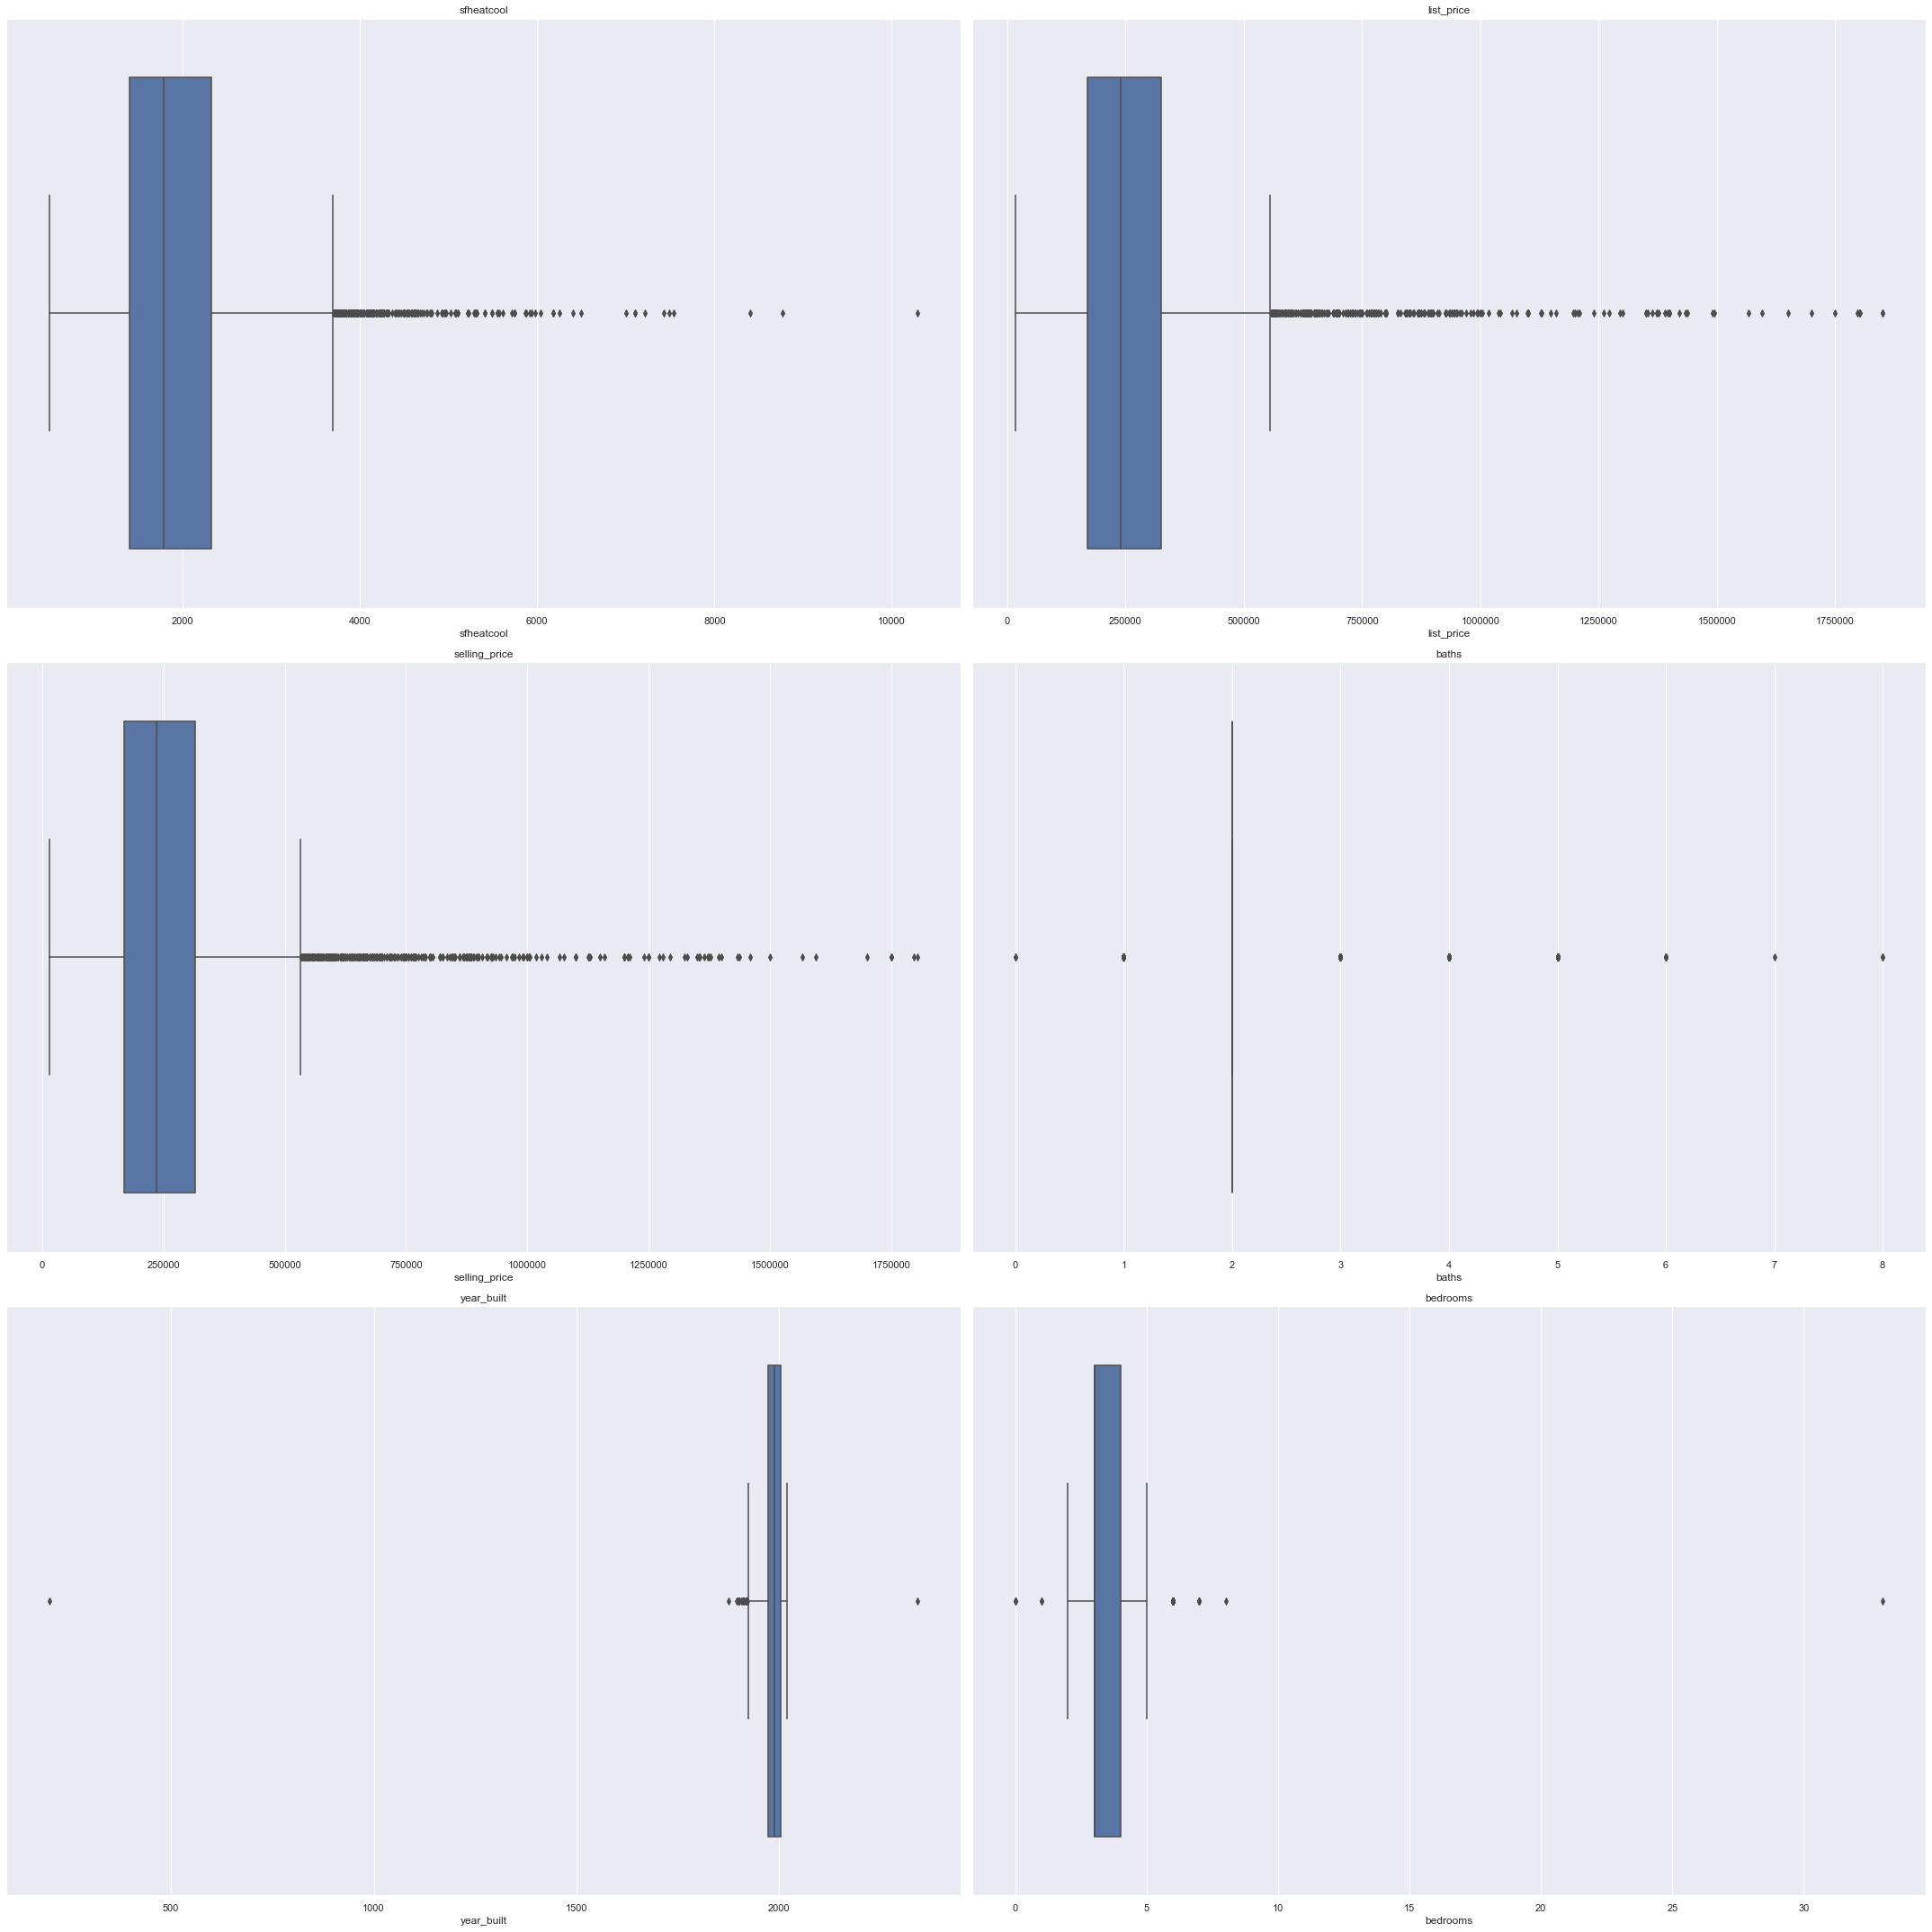

In [209]:
fig, axes = plt.subplots(3, 2, sharey=False)

sns.boxplot(real_estate['sfheatcool'], ax=axes[0, 0])
sns.boxplot(real_estate['list_price'], ax=axes[0, 1])
sns.boxplot(real_estate['selling_price'], ax=axes[1, 0])
sns.boxplot(real_estate['baths'], ax=axes[1, 1])
sns.boxplot(real_estate['year_built'], ax=axes[2, 0])
sns.boxplot(real_estate['bedrooms'], ax=axes[2, 1])

axes[0, 0].set_title('sfheatcool')
axes[0, 1].set_title('list_price')
axes[1, 0].set_title('selling_price')
axes[1, 1].set_title('baths')
axes[2, 0].set_title('year_built')
axes[2, 1].set_title('bedrooms')
                         
fig.set_size_inches(30, 30)
fig.tight_layout()

From these boxplots there are some pretty clear outliers I want to explore in each category.

#### Year Built

The year built are obvious user input errors, however accurately guessing what year should be there is impossible. Luckily I can double check user input errors using parcel ID via https://www.acpafl.org/searches/property-search/parcel-number-search/. The correct years have been input below.

In [210]:
real_estate[((real_estate['year_built'] > 2020) | (real_estate['year_built'] < 1800))].head()

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
3172,07054-202-175,Shingle,"Foundation-Slab, Frame",Hardiboard/Concr Siding,Other,Sink - Dual,"Alarm System, Compactor, Cooktop - Gas, Dishwa...",Wood,Other,Craftsman,"Carpet, Tile, Wood - Laminate",Great Room,"Cash, Conventional, FHA, USDA, VA",Cul-de-sac,0.28,235000,227166.0,1807,201.0,2.0,4.0,0.0,Other,2,Yes,No
5196,06849-002-006,Shingle,"Brick, Foundation-Slab",Wood,Other,"Separate Tub- Jetted, Walk-In Shower","Dishwasher, Disposal, Microwave, Oven - Wall, ...",Wood,Other,Traditional,"Carpet, Tile, Wood - Hardwood",Family Room,"Conventional, FHA, VA",Other,1.00,354000,340000.0,2340,2340.0,2.0,4.0,1.0,Other,2,Yes,No


In [211]:
real_estate.loc[real_estate['year_built'].eq(895), 'year_built'] = 1998

real_estate.loc[real_estate['year_built'].eq(201), 'year_built'] = 2001

real_estate.loc[real_estate['parcel_number'].eq('06849-002-006'), 'year_built'] = 1973

#### Bedrooms

In [212]:
real_estate[(real_estate['bedrooms'] > 10) | (real_estate['bedrooms'] == 0)].head(10)

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
31,11276-001-000,Metal,Other,"Wood, Other",Other,Single Vanity,None,"Other, None",Other,Other,Other,Other,Cash,"Corner Lot, Mostly Cleared/Grass, Other",0.45,30000,30000.0,1356,1946.0,1.0,0.0,0.0,Other,0,No,No
33,07882-012-000,Other,Other,Other,Other,None,None,None,None,Other,None,None,"Cash, Sold As Is, Title Ins Provided","Mostly Cleared/Grass, Pasture on Property, Rec...",0.26,34900,31000.0,500,1900.0,0.0,0.0,0.0,Other,0,No,No
122,14346-000-000,Metal,Frame,Wood,Other,None,None,Partial,Storage Shed,Craftsman,Other,None,Other,Rectangular-shaped,0.20,54900,54900.0,984,1930.0,0.0,0.0,0.0,Handyman Special,0,No,No
3805,06463-009-000,Shingle,Concrete Block,"Deco Brick/Stone, Concrete Block",Liv/Din Combo,None,None,Other,Other,Colonial,Other,Other,Other,Other,0.33,259900,253000.0,1900,1958.0,2.0,33.0,0.0,Other,1,Yes,No


Interesting! 0 bedrooms can be interpreted as a tinyhome. However, I will inpute those as having 1 bedroom just to match other inputs. 33 bedrooms looks like an anomaly, so I decided to double check the parcel id on https://www.acpafl.org/searches/property-search/parcel-number-search/ and discovered that it should be 3 bedrooms.

In [213]:
real_estate.loc[real_estate['bedrooms'].eq(0), 'bedrooms'] = 1

real_estate.loc[real_estate['parcel_number'].eq('06463-009-000'), 'bedrooms'] = 3

#### Bathrooms

Parcel ID '04427-111-333' shows up as vacant land in the county database. Since the data input can't be confirmed, it will be dropped. I'm also going to drop the parcel ids ['16239-006-000','07882-012-000', '06029-008-000'] as there are a number of incorrect inputs for those property.

In [214]:
real_estate[((real_estate['baths'] > 6) | (real_estate['baths'] < 1))].head(10)

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
33,07882-012-000,Other,Other,Other,Other,None,None,None,None,Other,None,None,"Cash, Sold As Is, Title Ins Provided","Mostly Cleared/Grass, Pasture on Property, Rec...",0.26,34900,31000.0,500,1900.0,0.0,1.0,0.0,Other,0,No,No
122,14346-000-000,Metal,Frame,Wood,Other,None,None,Partial,Storage Shed,Craftsman,Other,None,Other,Rectangular-shaped,0.20,54900,54900.0,984,1930.0,0.0,1.0,0.0,Handyman Special,0,No,No
3959,16239-006-000,Metal,"Frame, Metal/Steel",Wood,Other,Single Vanity,"Cooktop - Electric, Dryer, Microwave, Oven - E...",None,None,Cottage,"Carpet, Tile, Wood - Hardwood","Living Room, Master Downstairs","Cash, Conventional, Sold As Is","Irregular, Wooded Lot",5.00,269000,260000.0,3840,1900.0,8.0,8.0,0.0,Other,0,No,No
6394,06029-008-000,Shingle,"Concrete Block, Foundation-Slab","Conventional Stucco, Concrete Block","Breakfast Bar, Liv/Din Combo, Separate Dining ...","Exhaust Fan, Linen Closet in Bath, Separate Tu...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...","Chain Link, Partial, Wood, Other",None,"2 Story, Contemporary","Carpet, Tile, Wood - Hardwood","2nd Kitchen, Den/Ofc (Not Inc in Bd #), Family...","Cash, Conventional, Other","Irregular, Rectangular-shaped",2.60,858000,765000.0,5933,2001.0,7.0,6.0,2.0,Other,3,Yes,Yes
6524,04427-111-333,Shingle,Frame,Synthetic Stucco/EIFS,Other,"Built-In Shower Bench, Exhaust Fan, Jack & Jil...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,None,"2 Story, Contemporary","Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional","Wooded Lot, Sidewalks, Pie-shaped",1.30,1796929,1796929.0,7487,2018.0,8.0,7.0,0.0,New Construction,3,Yes,Yes


In [215]:
real_estate.loc[real_estate['parcel_number'].eq('14346-000-000'), 'baths'] = 1

real_estate = real_estate.loc[~real_estate['parcel_number'].isin(['04427-111-333','16239-006-000','07882-012-000', '06029-008-000']), :]

#### Half Baths

Both these parcels will be dropped as there are too many input errors when compared with the county records

In [216]:
real_estate[(real_estate['half-baths'] > 2)].head()

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
6469,06860-346-013,Shingle,Frame,Conventional Stucco,Other,"Built-In Shower Bench, Exhaust Fan, Jack & Jil...","Alarm System, Cooktop - Electric, Dishwasher, ...",Electric,Workshop,"2 Story, Traditional","Stone, Tile, Wood - Hardwood","2nd Kitchen, Bonus (Not Inc in Bd #), Den/Ofc ...","Cash, Conventional, Title Ins Provided","Square-shaped, Wooded Lot",0.61,1100000,983000.0,6250,2006.0,4.0,5.0,3.0,Other,4+,Yes,Yes
6507,06440-004-000,Shingle,"Foundation-Slab, Frame","Deco Brick/Stone, Wood","Breakfast Bar, Breakfast Nook, Eat-In Kitchen,...","Claw Foot Tub, Exhaust Fan, Sink - Dual, Water...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...","Partial, PVC",Other,"Colonial, Split-Level","No Carpeting, Tile, Wood - Hardwood","2nd Kitchen, Family Room, Foyer, In-Law Suite,...","Cash, Conventional",Wooded Lot,3.20,1595000,1355000.0,7107,1951.0,6.0,7.0,3.0,Other,3,Yes,Yes


In [217]:
real_estate = real_estate.loc[~real_estate['parcel_number'].isin(['06440-004-000','06860-346-013']), :]

#### Square Feet

These values look to be correct, but do represent many of the outliers in other categories. Since these only represet 16 sales, I will drop these values for the sake of efficiency.

In [218]:
real_estate[(real_estate['sfheatcool'] > 6000)].head(20)

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
6364,06415-003-001,Shingle,Frame,Deco Brick/Stone,Other,"Separate Tub- Garden, Split Vanities, Walk-In ...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,Storage Shed,"2 Story, Contemporary","Carpet, Tile, Wood - Hardwood","2nd Kitchen, Den/Ofc (Not Inc in Bd #), Family...",Other,"Pasture on Property, Wooded Lot",4.95,725000,725000.0,6179,1992.0,3.0,4.0,1.0,Other,2,Yes,Yes
6413,04322-020-005,Shingle,"Brick, Frame",Brick Veneer,Separate Dining Room,"Exhaust Fan, Walk-In Shower","Alarm System, Cooktop - Electric, Dishwasher, ...",Board (Horse),"Bathroom, Storage Shed, Other",Contemporary,"Carpet, Tile, Wood - Laminate","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional",Wooded Lot,2.00,879900,820000.0,6495,1992.0,4.0,5.0,1.0,Other,3,Yes,Yes
6449,07071-031-000,Shingle,"Brick, Frame",Brick Veneer,Other,"Linen Closet in Bath, Makeup/Vanity Space, Sep...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...","Wood, Other","1-5 Stall Barn(s), Water, Workshop, Other","2 Story, Traditional","Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional, Title Ins Provided, VA","Pasture on Property, Rectangular-shaped, Woode...",10.00,948000,895000.0,6404,2003.0,4.0,5.0,2.0,Other,3,Yes,Yes
6488,06860-361-004,Shingle,Other,Hardiboard/Concr Siding,Other,"Bidet, Built-In Shower Bench, Jack & Jill Bath...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Wood,Other,"2 Story, Traditional","Carpet, Tile, Wood - Hardwood","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...","Cash, Conventional, FHA, Other, USDA, VA","Cul-de-sac, Pie-shaped",2.10,1149000,1150000.0,7536,2002.0,6.0,7.0,2.0,Other,3,Yes,Yes
6497,07354-024-000,Shingle,Concrete Block,Conventional Stucco,Other,"Bidet, Exhaust Fan, Jack & Jill Bath, Linen Cl...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...","Board (Horse), Complete Perimeter, Wood","5+ Stall Barns, Bathroom, Center Aisle Barn, T...","2 Story, Mediterranean","Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional","Pasture on Property, Rectangular-shaped",55.59,1400000,1240000.0,6178,2000.0,4.0,5.0,2.0,Other,3,Yes,Yes
6498,04322-020-003,Shingle,Frame,Conventional Stucco,Other,"Linen Closet in Bath, Makeup/Vanity Space, Mul...","Alarm System, Cooktop - Electric, Dishwasher, ...",Other,None,"2 Story, Contemporary","Carpet, Tile","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...","Cash, Conventional, VA",Rectangular-shaped,2.02,1349000,1250000.0,7426,1988.0,5.0,6.0,0.0,Other,3,Yes,Yes
6499,06047-010-008,Shingle,"Brick, Frame","Brick Veneer, Deco Brick/Stone",Other,"Bidet, Exhaust Fan, Linen Closet in Bath, Make...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Other,None,"2 Story, Traditional","Carpet, Tile, Wood - Hardwood, Other","2nd Kitchen, Bonus (Not Inc in Bd #), Den/Ofc ...",Cash,"Cul-de-sac, Wooded Lot, Sidewalks",5.04,1299999,1250000.0,7216,2002.0,5.0,6.0,1.0,Other,3,Yes,Yes
6501,04290-020-016,Shingle,Frame,"Brick Veneer, Hardiboard/Concr Siding",Other,"Heated Floors, Jack & Jill Bath, Linen Closet ...","Alarm System, Cooktop - Electric, Dishwasher, ...",Board (Horse),None,"2 Story, Colonial","Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Family Room, Foyer, G...","Cash, Conventional, Title Ins Provided",Other,5.37,1389000,1279000.0,7000,2009.0,4.0,6.0,1.0,Other,4+,Yes,Yes
6509,06852-100-014,Shingle,"Foundation-Slab, Frame","Hardiboard/Concr Siding, Synthetic Stucco/EIFS","Breakfast Bar, Breakfast Nook, Separate Dining...","Built-In Shower Bench, Exhaust Fan, Multiple S...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,None,2 Story,"Tile, Wood - Hardwood

In [219]:
real_estate = real_estate[~(real_estate['sfheatcool'] > 6000)]

#### List Price

I wanted to do some exploring with list price, but through iterative EDA and model runs I discovered that list price is too predictive of sales price and end up dropping it before running my final model.

In [220]:
real_estate[(real_estate['list_price'] > 1400000)].head(10)

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
6454,06039-001-000,Metal,Frame,Deco Brick/Stone,Other,Sink - Dual,"Alarm System, Cooktop - Electric, Dishwasher, ...","Barbed Wire, Complete Perimeter, Mixed Type",Pole Barn,Ranch,"Carpet, Tile","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...",Cash,"Pasture on Property, Wooded Lot",86.00,1650000,907030.0,4744,1972.0,3.0,5.0,1.0,Other,2,Yes,Yes
6504,06035-015-007,Metal,Frame,"T-111, Other",Other,"Built-In Shower Bench, Exhaust Fan, Multiple S...","Cooktop - Gas, Dishwasher, Disposal, Dryer, Fr...",Mixed Type,Other,"Contemporary, Modern, Split-Level","Concrete - Finished, Marble, Tile, Wood - Hard...","2nd Kitchen, Family Room, Foyer, In-Law Suite,...","Cash, Conventional","Rectangular-shaped, Wooded Lot",10.00,1490000,1330000.0,5100,1982.0,4.0,4.0,2.0,Other,4+,Yes,Yes
6515,04427-111-099,Shingle,"Foundation-Slab, Frame","Deco Brick/Stone, Hardiboard/Concr Siding",Other,"Built-In Shower Bench, Linen Closet in Bath, R...","Cooktop - Gas, Dishwasher, Disposal, Microwave",None,None,"2 Story, Contemporary","Carpet, Tile, Vinyl, Wood - Hardwood","Bonus (Not Inc in Bd #), Family Room, Foyer, L...",Other,"Wooded Lot, Sidewalks",1.00,1433000,1433000.0,4970,2017.0,5.0,6.0,0.0,New Construction,3,Yes,Yes
6516,04427-111-109,Shingle,Frame,"Brick Veneer, Conventional Stucco",Other,"Jack & Jill Bath, Linen Closet in Bath, Makeup...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Wood,None,"2 Story, Traditional","Carpet, Tile, Wood - Hardwood","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...",Other,"Rectangular-shaped, Wooded Lot, Sidewalks",1.00,1437250,1437250.0,5547,2017.0,5.0,4.0,1.0,New Construction,3,Yes,Yes
6517,04427-111-102,Shingle,Frame,Conventional Stucco,"Breakfast Bar, Separate Dining Room","Built-In Shower Bench, Linen Closet in Bath, M...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Other,None,"2 Story, Contemporary","Carpet, Tile, Wood - Hardwood","Den/Ofc (Not Inc in Bd #), Foyer, Great Room, ...","Cash, Conventional, Title Ins Provided","Corner Lot, Rectangular-shaped, Wooded Lot, Si...",1.00,1419500,1460000.0,4626,2017.0,5.0,4.0,1.0,New Construction,3,Yes,Yes
6518,04427-111-332,Shingle,"Foundation-Slab, Frame","Hardiboard/Concr Siding, Synthetic Stucco/EIFS","Breakfast Nook, Separate Dining Room","Built-In Shower Bench, Exhaust Fan, Multiple S...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,None,2 Story,"Tile, Wood - Hardwood","Den/Ofc (Not Inc in Bd #), Family Room, Laundr...","Cash, Conventional","Rectangular-shaped, Wooded Lot, Sidewalks",1.00,1495000,1500000.0,5102,2019.0,6.0,5.0,0.0,New Construction,3,Yes,Yes
6519,04427-111-108,Shingle,"CB/Brick Front, Foundation-Slab, Frame","Deco Brick/Stone, Hardiboard/Concr Siding",Other,"Built-In Shower Bench, Jack & Jill Bath, Linen...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,None,2 Story,"Carpet, Tile, Wood - Laminate","Den/Ofc (Not Inc in Bd #), Foyer, Great Room, ...","Conventional, Title Ins Provided",Corner Lot,1.00,1565759,1565759.0,5489,2018.0,4.0,5.0,1.0,New Construction,3,Yes,Yes
6520,06660-010-002,"Metal, Shingle",Brick,"Brick Veneer, Wood","Breakfast Nook, Eat-In Kitchen, Separate Dinin...","Built-In Shower Bench, Claw Foot Tub, Exhaust ...","Alarm System, Cooktop - Gas, Dishwasher, Dryer...",Partial,None,"2 Story, Other","Slate, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Family Room, Foyer, L...","Cash, Conventional, May Pay Closing Costs, Tit...","Cul-de-sac, Wooded Lot, Pie-shaped",6.81,1799999,1595000.0,5978,1988.0,5.0,4.0,1.0,Other,3,Yes,Yes
6521,06347-000-000,Other,Brick,Brick Veneer,"Breakfast Bar, Breakfast Nook, Eat-In Kitchen","Claw Foot Tub, Exhaust Fan, Linen Closet in Ba...","Alarm System, Co

#### Sale Price

An early dive into my target variable shows some really interesting findings! Most houses over $1 million are under construction or are new constructions. The 9 properties that are not are likely custom homes constructed by famous architects. 

I may revisit this portion of data to winsorize the 15 properties that sold for over $1.3 million if that proves to be disruptive to my model. However, this information has value and I hesitate to drop the outliers.

In [221]:
real_estate[(real_estate['selling_price'] > 1000000)].head(50).sort_values(by = 'condition', ascending = False)

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
6495,06303-050-011,Shingle,"Foundation-Slab, Frame",Conventional Stucco,"Breakfast Bar, Kit/Din Combo","Built-In Shower Bench, Exhaust Fan, Jack & Jil...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Partial,None,"Contemporary, Modern","Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional, Title Ins Not Provided","Irregular, Pie-shaped",1.00,1209976,1209976.0,4465,2019.0,3.0,4.0,2.0,Under Construction,3,Yes,Yes
6487,07247-020-006,Shingle,Frame,"Deco Brick/Stone, Synthetic Stucco/EIFS","Breakfast Bar, Kit/Din Combo","Built-In Shower Bench, Linen Closet in Bath, M...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,None,2 Story,"Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Conventional, Title Ins Provided",Square-shaped,0.24,1129019,1129019.0,4521,2018.0,5.0,4.0,0.0,Under Construction,3,Yes,Yes
6506,044277-111-403,Shingle,"Foundation-Slab, Frame",Synthetic Stucco/EIFS,"Breakfast Bar, Kit/Din Combo","Exhaust Fan, Jack & Jill Bath, Linen Closet in...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Other,None,Mediterranean,"Carpet, Tile, Wood - Hardwood","Den/Ofc (Not Inc in Bd #), Foyer, Great Room, ...","Cash, Conventional, Title Ins Not Provided","Corner Lot, Rectangular-shaped, Wooded Lot, Si...",1.00,1353037,1353037.0,3925,2019.0,3.0,4.0,2.0,Under Construction,3,Yes,Yes
6481,04326-000-000,Tile,Frame,Synthetic Stucco/EIFS,"Breakfast Bar, Kit/Din Combo","Built-In Shower Bench, Linen Closet in Bath, M...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",None,None,"2 Story, Mediterranean","Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Conventional, Title Ins Not Provided","Rectangular-shaped, Wooded Lot",5.00,1076019,1076019.0,5078,2018.0,5.0,6.0,0.0,Under Construction,3,Yes,No
6489,04427-111-101,Shingle,Frame,Conventional Stucco,"Breakfast Bar, Kit/Din Combo","Linen Closet in Bath, Multiple Shower Heads, S...","Alarm System, Cooktop - Gas, Dishwasher, Micro...",Other,None,Contemporary,"Carpet, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional, Title Ins Not Provided","Rectangular-shaped, Wooded Lot, Sidewalks",1.00,1158901,1158901.0,4309,2019.0,4.0,4.0,2.0,Under Construction,3,Yes,No
6486,04427-111-103,Shingle,Frame,"Deco Brick/Stone, Synthetic Stucco/EIFS",Kit/Din Combo,"Built-In Shower Bench, Jack & Jill Bath, Linen...","Alarm System, Cooktop - Electric, Dishwasher, ...",None,None,Contemporary,"Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...",Conventional,Rectangular-shaped,1.00,1128235,1128235.0,4230,2018.0,4.0,4.0,1.0,Under Construction,3,Yes,Yes
6521,06347-000-000,Other,Brick,Brick Veneer,"Breakfast Bar, Breakfast Nook, Eat-In Kitchen","Claw Foot Tub, Exhaust Fan, Linen Closet in Ba...","Alarm System, Cooktop - Gas, Dishwasher, Dispo...",Cross,"1-5 Stall Barn(s), Bathroom, Tack Room, Water",Traditional,Wood - Hardwood,"Bonus (Not Inc in Bd #), Den/Ofc (Not Inc in B...","Cash, Conventional",Irregular,9.17,1700000,1700000.0,4155,1987.0,3.0,4.0,1.0,Other,4+,Yes,No
6520,06660-010-002,"Metal, Shingle",Brick,"Brick Veneer, Wood","Breakfast Nook, Eat-In Kitchen, Separate Dinin...","Built-In Shower Bench, Claw Foot Tub, Exhaust ...","Alarm System, Cooktop - Gas, Dishwasher, Dryer...",Partial,None,"2 Story, Other","Slate, Tile, Wood - Hardwood","Bonus (Not Inc in Bd #), Family Room, Foyer, L...","Cash, Conventional, May Pay Closing Costs, Tit...","Cul-de-sac, Wooded Lot, Pie-shaped",6.81,1799999,1595000.0,5978,1988.0,5.0,4.0,1.0,Other,3,Yes,Yes
6504,06035-015-007,Metal,Frame,"T-111, Other",Other,"Built

In [222]:
# combined2_df[(combined2_df['selling_price'] < 50000)].info()

#### Parcel size (acres)

In [223]:
real_estate[(real_estate['parcel_size_(acres)'] > 20)].head(50).sort_values(by = 'condition', ascending = False)

,parcel_number,roof,construction_type,exterior_finish,dining_area,bathroom_features,appliances/equipment,fencing,outbuilding_features,style,floors,interior_layout,terms,lot_info,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths,condition,#_of_garage_spaces,garage_y/n,pool_y/n
3399,15136001000,Shingle,Concrete Block,Concrete Block,Kit/Din Combo,Single Vanity,Oven - Electric,None,None,Cottage,Wood - Hardwood,Great Room,May Exchange,Cul-de-sac,6848.00,239000,235000.0,1448,1961.0,2.0,3.0,0.0,Other,0,No,No
5502,05794-002-000,Metal,"Concrete Block, Frame",Other,Other,"Sink - Dual, Tub/Shower Combo, Walk-In Shower","Cooktop - Electric, Dishwasher, Dryer, Microwa...","Mixed Type, Woven Wire","Pole Barn, Storage Shed","2 Story, Ranch","Carpet, Tile, Wood - Hardwood","Great Room, Laundry/Utility Room, Master Downs...","Cash, Title Ins Provided","Pasture on Property, Wooded Lot",22.18,399900,375000.0,2750,2004.0,2.0,3.0,1.0,Other,0,No,Yes
5816,06672-200-101,Shingle,Frame,"Conventional Stucco, Hardiboard/Concr Siding",Other,"Exhaust Fan, Separate Tub- Jetted, Walk-In Sho...","Alarm System, Dishwasher, Disposal, Microwave,...","Privacy, Wood",Workshop,Contemporary,"Carpet, Tile","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...",Title Ins Provided,Corner Lot,34.00,429900,429900.0,2771,2003.0,3.0,4.0,1.0,Other,2,Yes,No
6116,07678-005-000,Shingle,Frame,Hardiboard/Concr Siding,Other,Makeup/Vanity Space,"Alarm System, Dishwasher, Dryer, Oven - Electr...",Wood,Power,"2 Story, Contemporary","Carpet, Tile, Wood - Hardwood","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...",Title Ins Provided,"Pasture on Property, Wooded Lot",161.00,520000,520000.0,3249,1981.0,4.0,5.0,2.0,Other,2,Yes,No
6454,06039-001-000,Metal,Frame,Deco Brick/Stone,Other,Sink - Dual,"Alarm System, Cooktop - Electric, Dishwasher, ...","Barbed Wire, Complete Perimeter, Mixed Type",Pole Barn,Ranch,"Carpet, Tile","Den/Ofc (Not Inc in Bd #), Family Room, Foyer,...",Cash,"Pasture on Property, Wooded Lot",86.00,1650000,907030.0,4744,1972.0,3.0,5.0,1.0,Other,2,Yes,Yes
6523,04308-000-000,Other,Frame,Other,Other,Exhaust Fan,None,Mixed Type,None,Cracker,Other,Other,Cash,Pasture on Property,70.00,1850000,1750000.0,1050,1930.0,1.0,3.0,0.0,Other,0,No,No
5475,05773-002-000,Other,Frame,Wood,Separate Dining Room,"Exhaust Fan, Sink - Dual, Tub/Shower Combo, Wa...",None,"Barbed Wire, Woven Wire",None,2 Story,"Carpet, Vinyl","Den/Ofc (Not Inc in Bd #), Family Room, Great ...","Cash, Conventional, Other, Sold As Is, Title I...","Irregular, Mostly Cleared/Grass, Pasture on Pr...",63.00,425000,372500.0,2562,1974.0,3.0,4.0,0.0,Handyman Special,3,Yes,Yes


In [224]:
real_estate = real_estate[~(real_estate['parcel_size_(acres)'] > 20)]

#### Revisiting the boxplot distributions

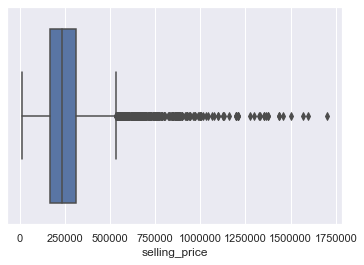

In [225]:
sns.boxplot(real_estate['selling_price'])
fig.savefig("saleprice.png")


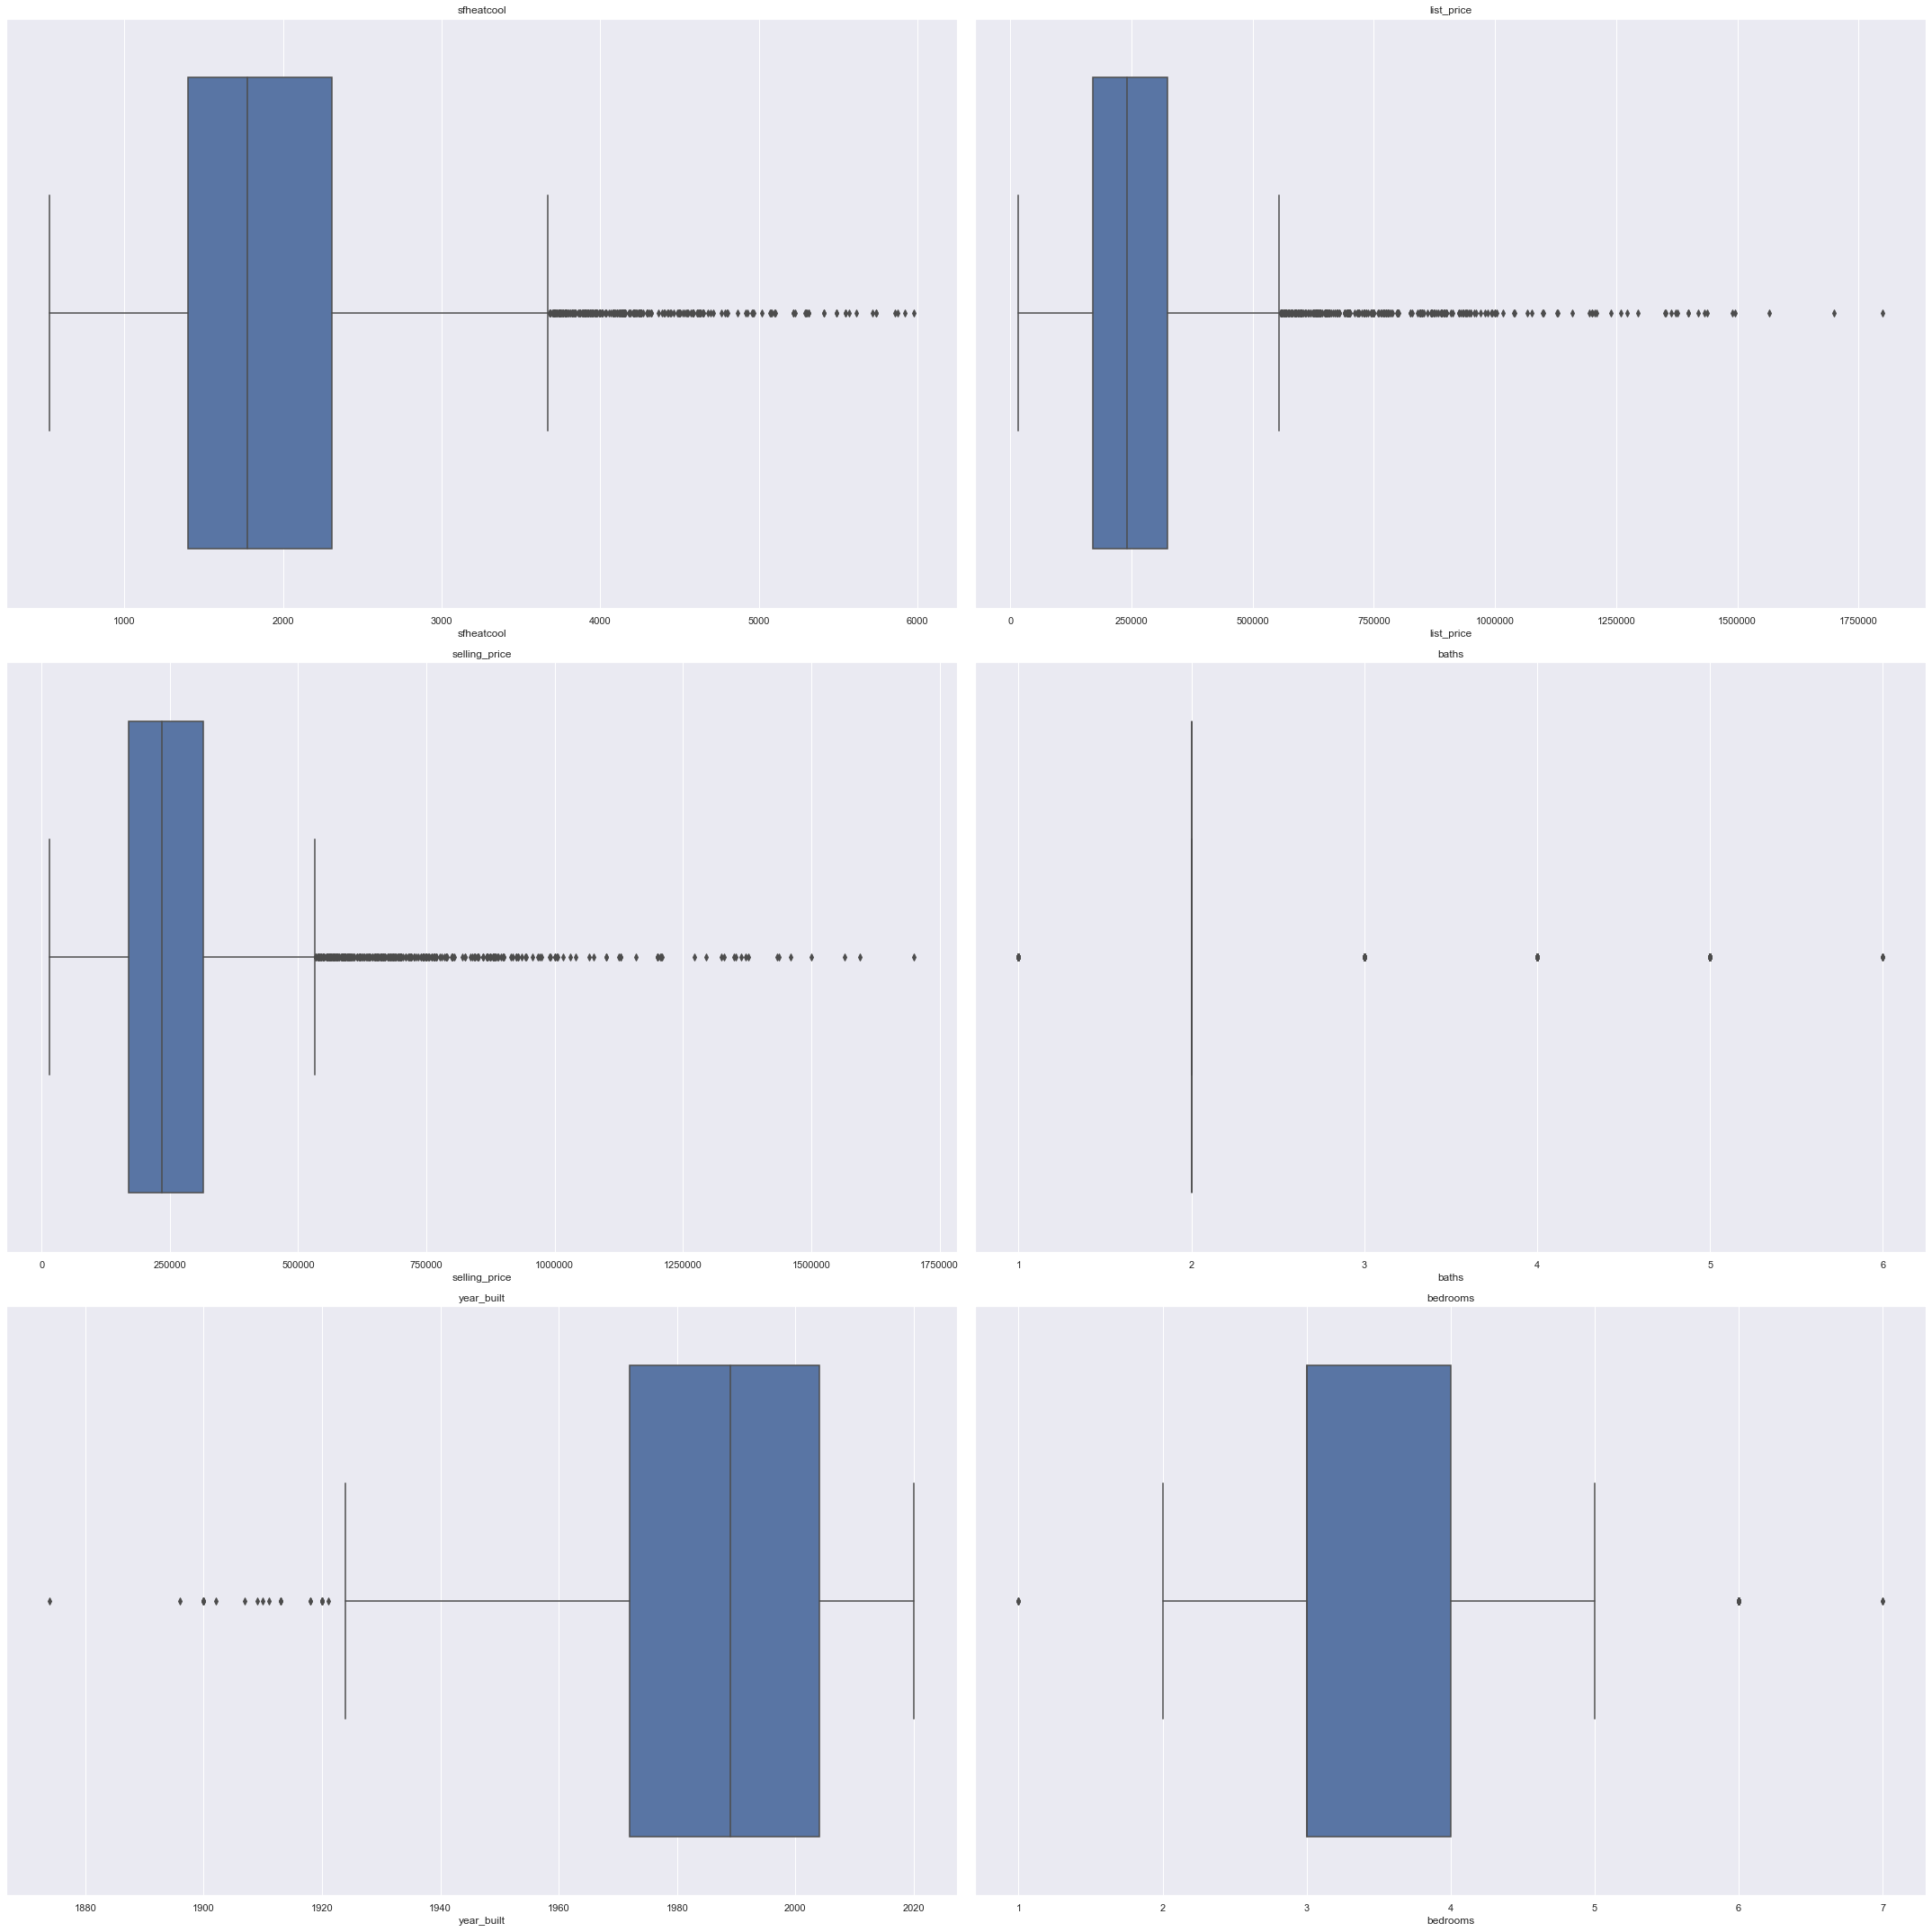

In [226]:
fig, axes = plt.subplots(3, 2, sharey=False)
                         
sns.boxplot(real_estate['sfheatcool'], ax=axes[0, 0])
sns.boxplot(real_estate['list_price'], ax=axes[0, 1])
sns.boxplot(real_estate['selling_price'], ax=axes[1, 0])
sns.boxplot(real_estate['baths'], ax=axes[1, 1])
sns.boxplot(real_estate['year_built'], ax=axes[2, 0])
sns.boxplot(real_estate['bedrooms'], ax=axes[2, 1])

axes[0, 0].set_title('sfheatcool')
axes[0, 1].set_title('list_price')
axes[1, 0].set_title('selling_price')
axes[1, 1].set_title('baths')
axes[2, 0].set_title('year_built')
axes[2, 1].set_title('bedrooms')

fig.set_size_inches(30, 30)
fig.tight_layout()

In [227]:
real_estate.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,parcel_size_(acres),list_price,selling_price,sfheatcool,year_built,baths,bedrooms,half-baths
count,6088,6088,6088,6088,6088,6088,6088,6088
mean,0.515784,272980,266928,1942.93,1986.92,2.19941,3.36071,0.174934
std,1.14694,163839,160817,772.875,21.6354,0.689035,0.723003,0.395617
min,0,17000,16000,528,1874,1,1,0
25%,0.19,170000,169000,1398,1972,2,3,0
50%,0.26,239900,234439,1775,1989,2,3,0
75%,0.4,324236,315000,2308,2004,2,4,0
max,20,1.8e+06,1.7e+06,5978,2020,6,7,2


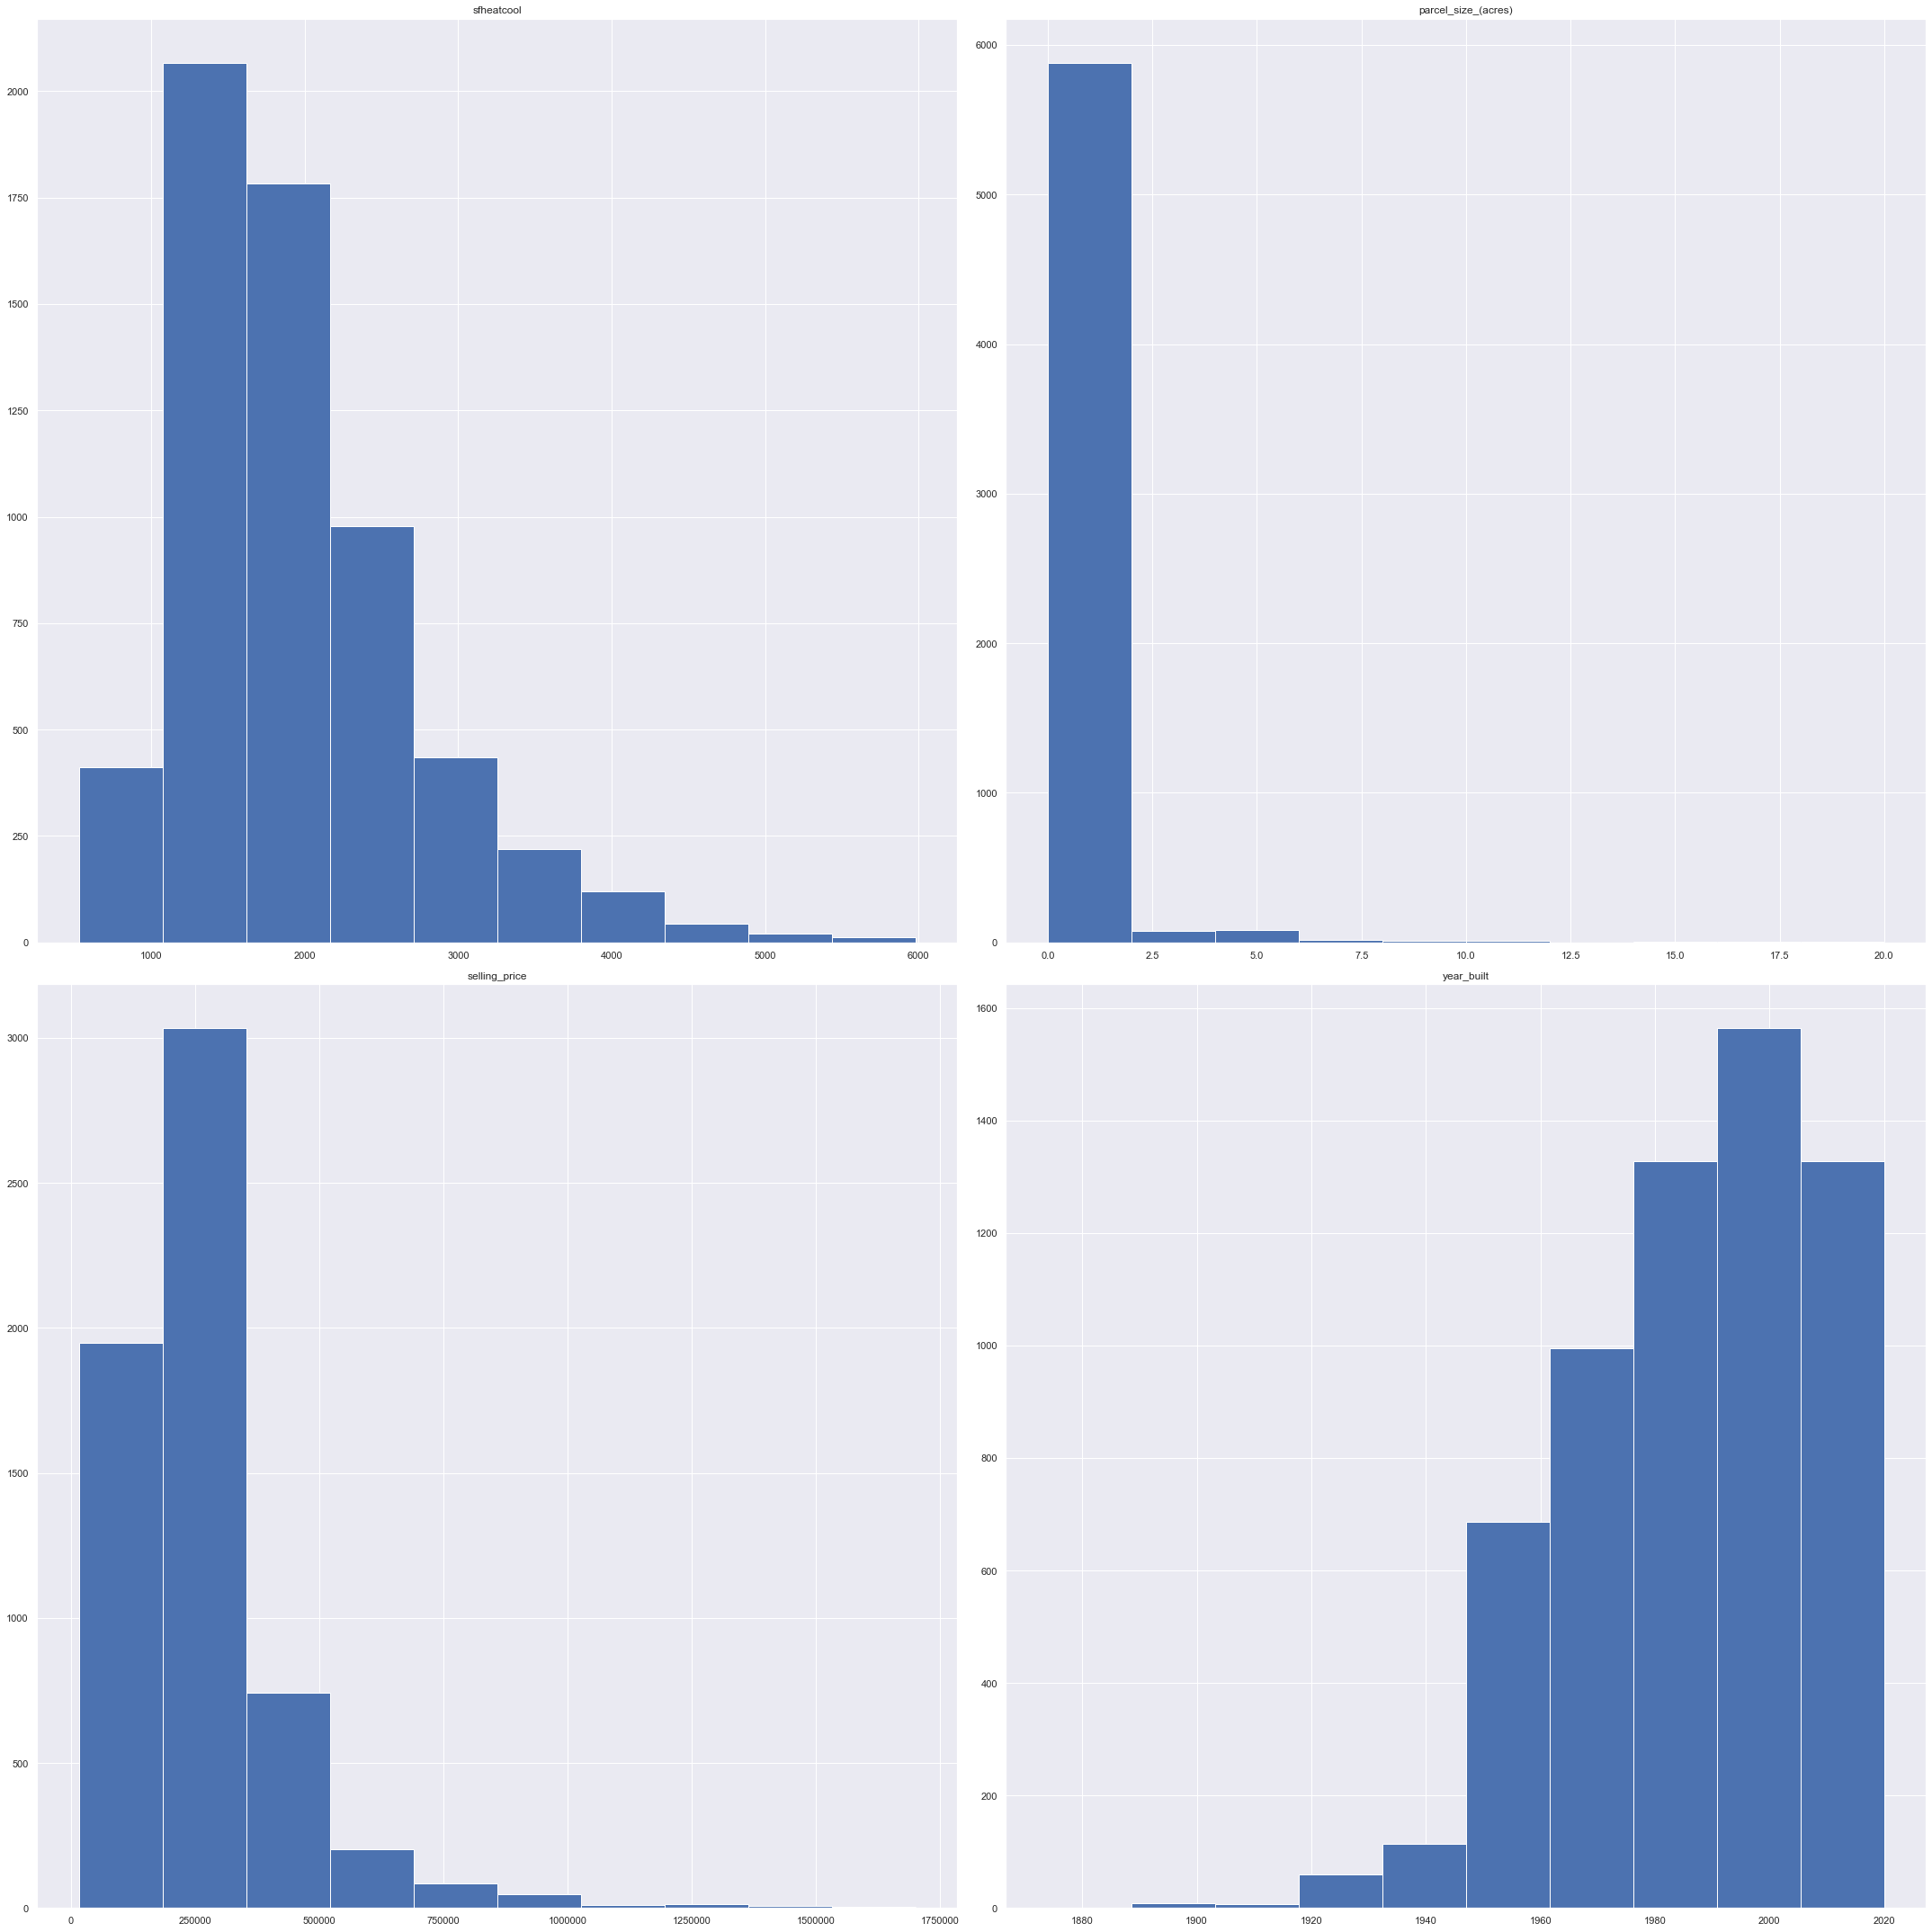

In [228]:
fig, axes = plt.subplots(2, 2, sharey=False)
                         
axes[0, 0].hist(real_estate['sfheatcool'])
axes[0, 1].hist(real_estate['parcel_size_(acres)'])
axes[1, 0].hist(real_estate['selling_price'])
axes[1, 1].hist(real_estate['year_built'])

axes[0, 0].set_title('sfheatcool')
axes[0, 1].set_title('parcel_size_(acres)')
axes[1, 0].set_title('selling_price')
axes[1, 1].set_title('year_built')
fig.savefig("histo.png")
                         
fig.set_size_inches(30, 30)
fig.tight_layout()

## Feature Engineering

### Continous Variable Relationship with Target

In [229]:
features_df = real_estate.drop(columns = ['parcel_number'])

In [230]:
features_df.columns

Index(['roof', 'construction_type', 'exterior_finish', 'dining_area',
       'bathroom_features', 'appliances/equipment', 'fencing',
       'outbuilding_features', 'style', 'floors', 'interior_layout', 'terms',
       'lot_info', 'parcel_size_(acres)', 'list_price', 'selling_price',
       'sfheatcool', 'year_built', 'baths', 'bedrooms', 'half-baths',
       'condition', '#_of_garage_spaces', 'garage_y/n', 'pool_y/n'],
      dtype='object')

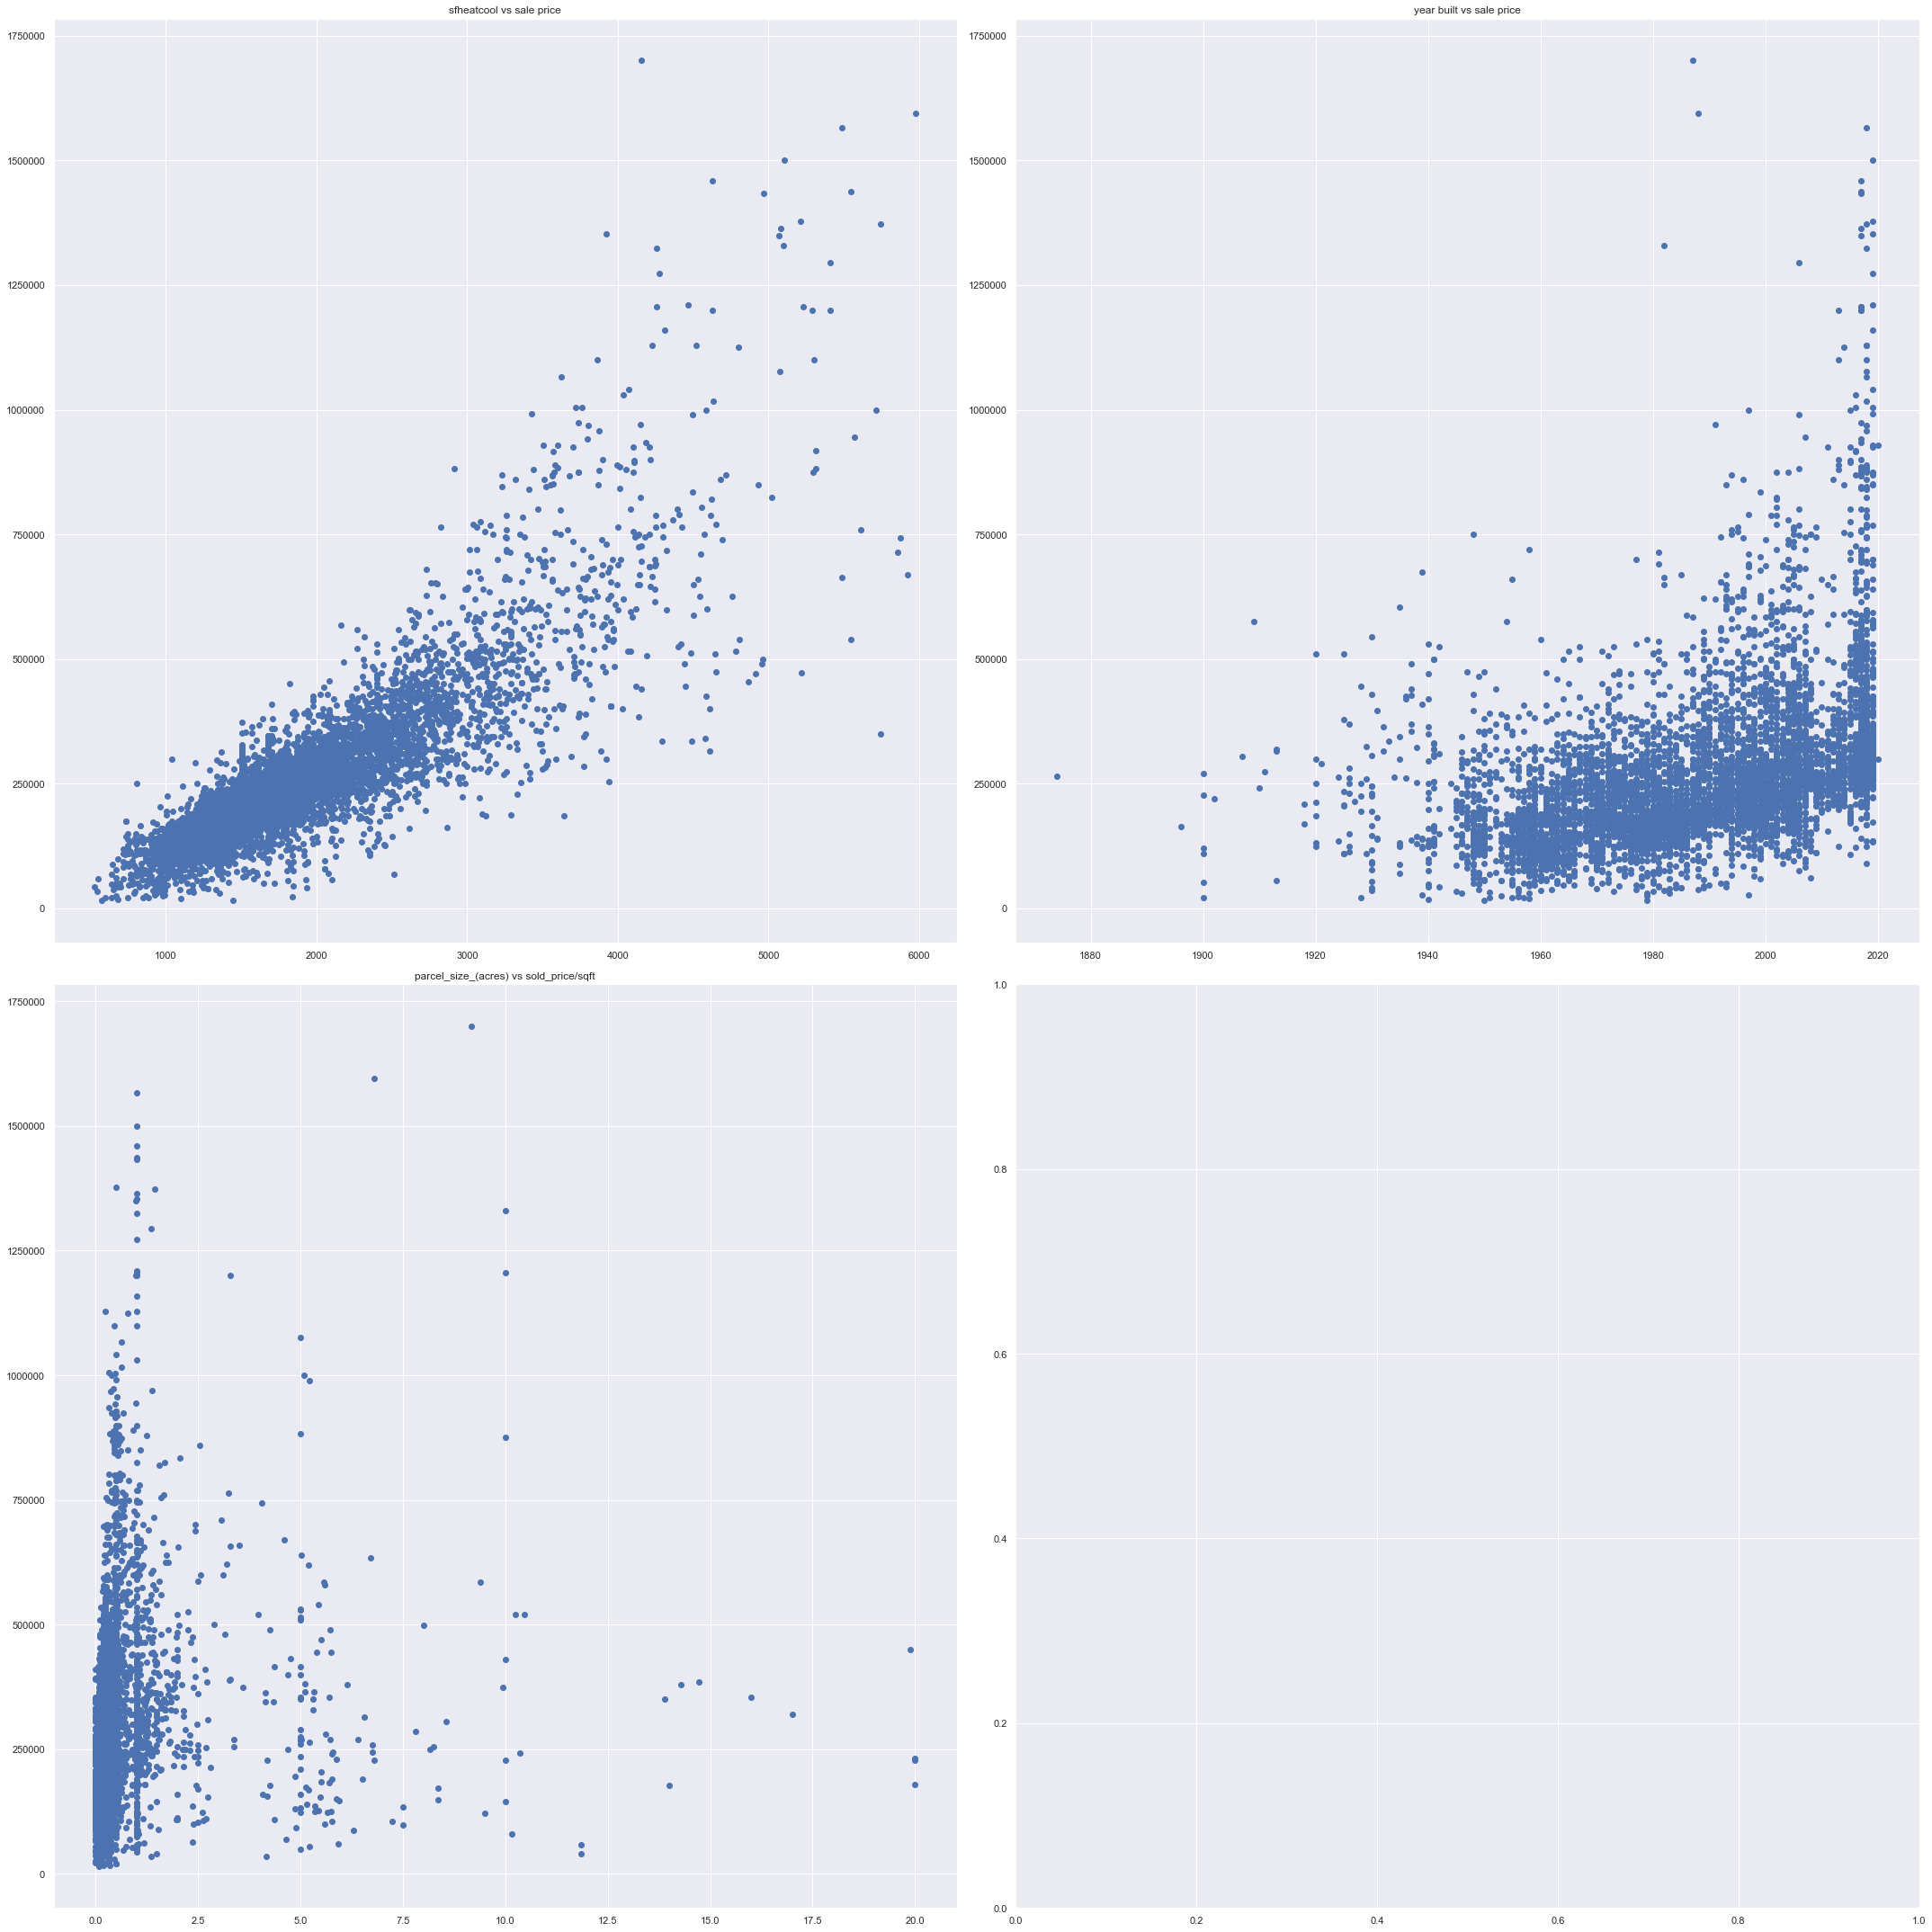

In [231]:
fig.set_size_inches(12, 6)

fig, axes = plt.subplots(2, 2, sharey=False)
                         
axes[0, 0].scatter(features_df['sfheatcool'], features_df['selling_price'])
axes[0, 1].scatter(features_df["year_built"], features_df['selling_price'])
axes[1, 0].scatter(features_df["parcel_size_(acres)"], features_df['selling_price'])


axes[0, 0].set_title('sfheatcool vs sale price')
axes[0, 1].set_title('year built vs sale price')
axes[1, 0].set_title('parcel_size_(acres) vs sold_price/sqft')


                         
fig.set_size_inches(30, 30)


fig.tight_layout()
plt.show()

(8.0, 0.0)

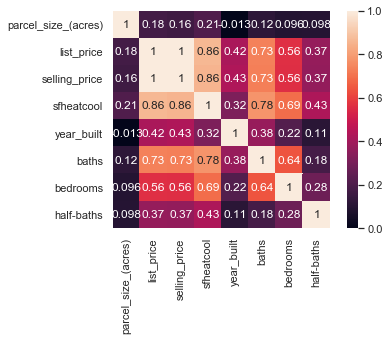

In [232]:
relationships = features_df.corr()

ax = sns.heatmap(relationships, vmin = 0, vmax = 1, square = True, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

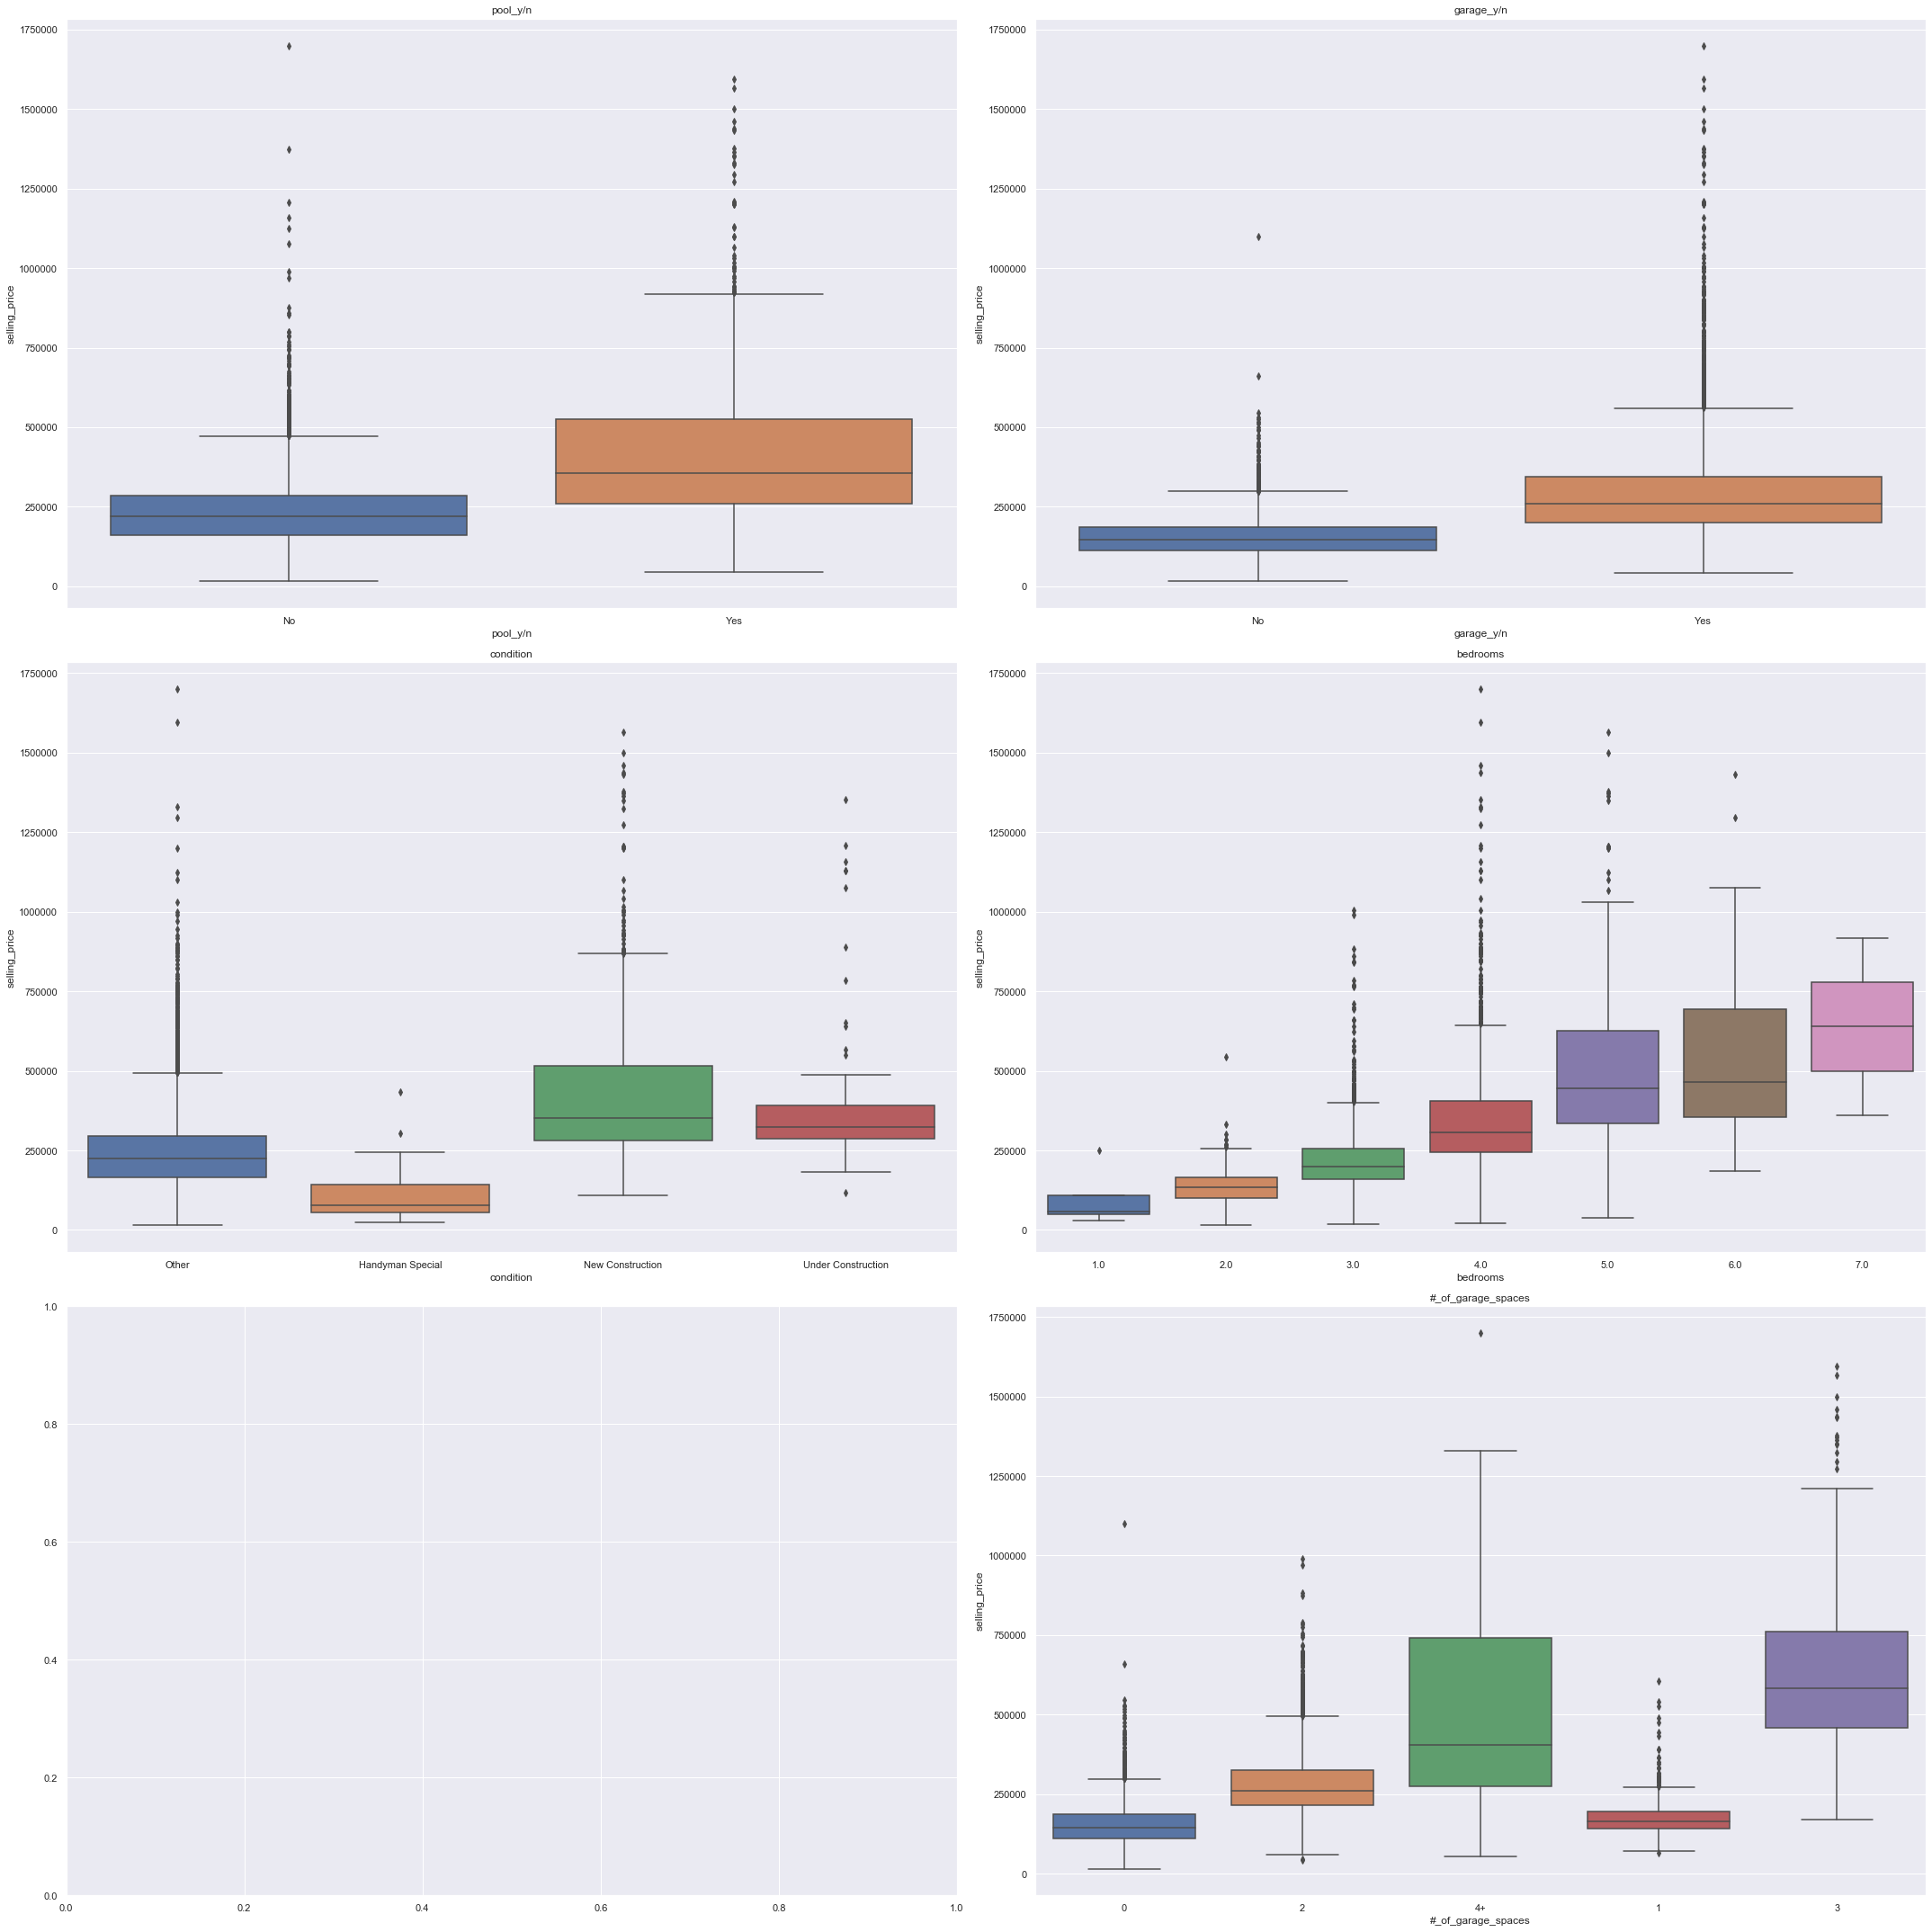

In [233]:
fig, axes = plt.subplots(3, 2, sharey=False)

sns.boxplot('pool_y/n', 'selling_price', data = features_df, ax=axes[0, 0])
sns.boxplot('garage_y/n', 'selling_price', data = features_df, ax=axes[0, 1])
sns.boxplot('condition', 'selling_price', data = features_df, ax=axes[1, 0])
sns.boxplot('bedrooms', 'selling_price', data = features_df, ax=axes[1, 1])
# sns.boxplot('lot_info', 'selling_price', data = features_df, ax=axes[2, 0]) This graph wasn't useful
sns.boxplot('#_of_garage_spaces', 'selling_price', data = features_df, ax=axes[2, 1])

axes[0, 0].set_title('pool_y/n')
axes[0, 1].set_title('garage_y/n')
axes[1, 0].set_title('condition')
axes[1, 1].set_title('bedrooms')
# axes[2, 0].set_title('lot_info')
axes[2, 1].set_title('#_of_garage_spaces')
                         
fig.set_size_inches(30, 30)
fig.tight_layout()

__note__: the following boxplot sets were omitted due to the variety of features present after I decided to omit the wrangling function above during iterative EDA.

In [234]:
# fig, axes = plt.subplots(3, 2, sharey=False)

# sns.boxplot('bathroom_features', 'selling_price', data = features_df, ax=axes[0, 0])
# sns.boxplot('construction_type', 'selling_price', data = features_df, ax=axes[0, 1])
# sns.boxplot('roof', 'selling_price', data = features_df, ax=axes[1, 0])
# sns.boxplot('exterior_finish', 'selling_price', data = features_df, ax=axes[1, 1])
# sns.boxplot('dining_area', 'selling_price', data = features_df, ax=axes[2, 0])
# sns.boxplot('appliances/equipment', 'selling_price', data = features_df, ax=axes[2, 1])

# axes[0, 0].set_title('bathroom_features')
# axes[0, 1].set_title('construction_type')
# axes[1, 0].set_title('roof')
# axes[1, 1].set_title('exterior_finish')
# axes[2, 0].set_title('dining_area')
# axes[2, 1].set_title('appliances/equipment')
                         
# fig.set_size_inches(30, 30)
# fig.tight_layout()

In [235]:
# fig, axes = plt.subplots(3, 2, sharey=False)

# sns.boxplot('fencing', 'selling_price', data = features_df, ax=axes[0, 0])
# sns.boxplot('outbuilding_features', 'selling_price', data = features_df, ax=axes[0, 1])
# sns.boxplot('style', 'selling_price', data = features_df, ax=axes[1, 0])
# sns.boxplot('floors', 'selling_price', data = features_df, ax=axes[1, 1])
# sns.boxplot('interior_layout', 'selling_price', data = features_df, ax=axes[2, 0])
# sns.boxplot('terms', 'selling_price', data = features_df, ax=axes[2, 1])

# axes[0, 0].set_title('fencing')
# axes[0, 1].set_title('outbuilding_features')
# axes[1, 0].set_title('style')
# axes[1, 1].set_title('floors')
# axes[2, 0].set_title('interior_layout')
# axes[2, 1].set_title('terms')
                         
# fig.set_size_inches(30, 30)
# fig.tight_layout()

In [236]:
features_df.columns

Index(['roof', 'construction_type', 'exterior_finish', 'dining_area',
       'bathroom_features', 'appliances/equipment', 'fencing',
       'outbuilding_features', 'style', 'floors', 'interior_layout', 'terms',
       'lot_info', 'parcel_size_(acres)', 'list_price', 'selling_price',
       'sfheatcool', 'year_built', 'baths', 'bedrooms', 'half-baths',
       'condition', '#_of_garage_spaces', 'garage_y/n', 'pool_y/n'],
      dtype='object')

## Dummie Split Function

Mentioned above, this function splits the features with multiple inputs on the string level.

I also iteratively dropped dining_area as a feature in my model as it was creating outlier results

In [237]:
features_df = features_df.drop(columns = ['dining_area'])

columnset = ['appliances/equipment', 'roof', 'construction_type', 'exterior_finish', 'bathroom_features', 'fencing', 'outbuilding_features', 'style', 'floors', 'interior_layout', 'terms', 'lot_info',
            'condition']

def get_dumb(x):
    dummie_dfs = []
    for y in x:
        dummie_df = features_df[y].str.get_dummies(sep=',')
        dummie_df.drop(columns = [dummie_df.columns[0]])
        dummie_dfs.append(dummie_df)
    full_dumb = pd.concat(dummie_dfs, axis = 1)
    return full_dumb

some_dumb = get_dumb(columnset)

feature2 = pd.concat([features_df, some_dumb], axis = 1)

feature2 = feature2.drop(columns=columnset)

In [238]:
feature2['total_bath'] = feature2['baths'] + (feature2['half-baths']/2)

In [239]:
feature2 = feature2.drop(columns = ['baths', 'half-baths'])

In [240]:
dumbs = ['#_of_garage_spaces', 'garage_y/n', 'pool_y/n']

model_df = pd.get_dummies(feature2, dumbs, drop_first = True)

## Some last second lever pulling

During iterative model running I discovered that having non-normalized sales prices was making my results relatively unstable, so I dropped the outliers seen earlier in my sales data.

In [241]:
model_df = model_df.loc[(model_df['selling_price'] < 1200000)]
model_df = model_df.loc[(model_df['selling_price'] > 50000)]

In [242]:
Y = model_df['selling_price']
X = model_df.drop(columns = ['selling_price', 'list_price'])

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [243]:
X1 = sm.add_constant(X)

results = sm.OLS(Y, X1).fit()

results.summary()

C:\Users\sgfis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     118.1
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:26:53   Log-Likelihood:                -73161.
No. Observations:                6000   AIC:                         1.471e+05
Df Residuals:                    5606   BIC:                         1.498e+05
Df Model:                         393                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.537e+05   6.76e+04     -6.710      0.000   -5.86e+05   -3.21e+05
parcel_size_(acres)         2040.5737    782.542      2.608      0.009     506.489    3574.658
sfheatcool                   103.6594      2.308     44.920      0.000      99.135     108.183
year_built                   483.2063     69.791      6.924      0.000     346.389     620.024
bedrooms                   -6232.5438   1411.047     -4.417      0.000   -8998.742   -3466.346
 Compactor                 -7136.3007   1.07e+04     -0.666      0.506   -2.82e+04    1.39e+04
 Cooktop - Electric        -2445.4916   3492.786     -0.700      0.484   -9292.705    4401.722
 Cooktop - Gas              3.798e+04   4008.118      9.475      0.000    3.01e+04    4.58e+04
 Dishwasher                 8457.4365   2774.420      3.048      0.002    3018.499    1.39e+04
 Disposal                   2710.3392   1695.058      1.599      0.110    -612.631    6033.309
 Dryer                     -8352.7869   3815.392     -2.189      0.029   -1.58e+04    -873.141
 Freestanding Icemaker      3612.6898   1.06e+04      0.341      0.733   -1.71e+04    2.44e+04
 Freezer                    -445.8867   4368.984     -0.102      0.919   -9010.787    8119.014
 Generator                   1.12e+04   9573.868      1.170      0.242   -7567.739       3e+04
 Microwave                  4786.5184   1621.008      2.953      0.003    1608.716    7964.321
 None                       6289.6263   2.14e+04      0.295      0.768   -3.56e+04    4.82e+04
 Oven - Convection          5159.7664   3263.325      1.581      0.114   -1237.614    1.16e+04
 Oven - Double              9996.4362   3717.539      2.689      0.007    2708.621    1.73e+04
 Oven - Electric            2908.2374   1792.152      1.623      0.105    -605.074    6421.549
 Oven - Gas                   38.6166   2806.128      0.014      0.989   -5462.480    5539.713
 Oven - Steam               6.407e+04    5.3e+04      1.208      0.227   -3.99e+04    1.68e+05
 Oven - Wall                6652.9455   3737.087      1.780      0.075    -673.192     1.4e+04
 Oven - Warming            -2340.2448   8883.422     -0.263      0.792   -1.98e+04    1.51e+04
 Oven/Stove                 -960.5554   1864.847     -0.515      0.607   -4616.377    2695.266
 Radon Mitigation System    3587.7738   7377.353      0.486      0.627   -1.09e+04    1.81e+04
 Refrigerator               3313.6635   2089.213      1.586      0.113    -782.003    7409.330
 Satellite Dish            -4419.6097   4172.198     -1.059      0.290   -1.26e+04    3759.514
 Security/Prewired         -4974.3847   2198.370     -2.263      0.024   -9284.041    -664.728
 TV Antenna                -1.007e+04   9944.522     -1.013      0.311   -2.96e+04    9424.990
 Washer                     5687.1258   378

Mean of the errors in the sale price model model is: 0.025927083333333333


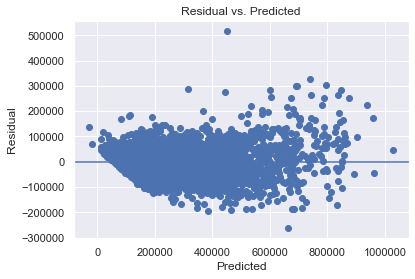

In [244]:
predictions = lrm.predict(X)
errors = Y - predictions

sns.set(font_scale = 1)

print("Mean of the errors in the sale price model model is: {}".format(np.mean(errors)))

plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
fig.tight_layout()
plt.show()

In [245]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 5731.3 and p value is 0
Levene test statistic value is 2169.78 and p value is 0


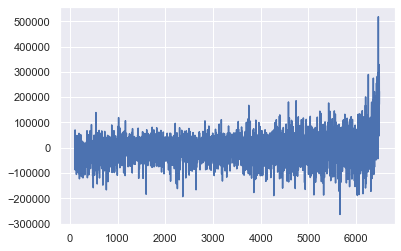

In [246]:
plt.plot(errors)
plt.show()

In [247]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 10669.29090861477 and p value is 0.0
Normality test statistics is 1187.9355395569028 and p value is 1.1042697027761624e-258


In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 4800
The number of observations in test set is 1200


In [249]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

C:\Users\sgfis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     99.18
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:26:55   Log-Likelihood:                -58472.
No. Observations:                4800   AIC:                         1.177e+05
Df Residuals:                    4411   BIC:                         1.202e+05
Df Model:                         388                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

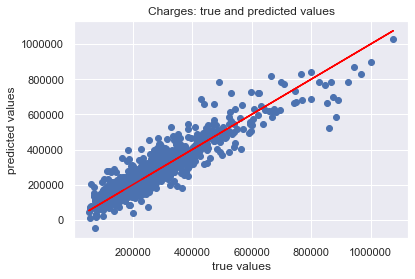

Mean absolute error of the prediction is: 38832.49877489207
Mean squared error of the prediction is: 2983298939.2536263
Root mean squared error of the prediction is: 54619.583843651046
Mean absolute percentage error of the prediction is: 17.37922466669927


In [250]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [251]:
Y = model_df['selling_price']
X = model_df.drop(columns = ['selling_price', 'list_price'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 4800
The number of observations in test set is 1200
R-squared of the model in the training set is: 0.8971655363289822
-----Test set statistics-----
R-squared of the model in the test set is: -21877838026693.32
Mean absolute error of the prediction is: 39221842806.16036
Mean squared error of the prediction is: 4.201758562374543e+23
Root mean squared error of the prediction is: 648209731674.4437
Mean absolute percentage error of the prediction is: 18892381.30092448


Hmmm looks like I am amazingly overfitting. Luckily there are some additional regression tests we can run to solve this. I believe Lasso should work wonders to help regularize the model

In [252]:
from sklearn.linear_model import Lasso

Y = model_df['selling_price']
X = model_df.drop(columns = ['selling_price', 'list_price'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

lassoregr = Lasso(alpha= 100) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

train_score= lassoregr.score(X_train, y_train)
test_score= lassoregr.score(X_test, y_test)
coeff_used = np.sum(lassoregr.coef_!=0)

print ("training score: {}".format(train_score)) 
print ("test score: {}".format(test_score))
print ("number of features used: {} ".format(coeff_used))
print('-------------------------------------------------')

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

training score: 0.8868348806534583
test score: 0.8599730212326264
number of features used: 171 
-------------------------------------------------
R-squared of the model on the training set is: 0.8868348806534583
-----Test set statistics-----
R-squared of the model on the test set is: 0.8599730212326264
Mean absolute error of the prediction is: 36514.372131609445
Mean squared error of the prediction is: 2689294784.43602
Root mean squared error of the prediction is: 51858.41093242272
Mean absolute percentage error of the prediction is: 16.209045261398593


In [253]:
tender_lasso = lassoregr.coef_[lassoregr.coef_!=0]
coef_dict = {}
for coef, feat in zip(tender_lasso, X_train):
    coef_dict[feat] = coef

In [254]:
lasso_coefficients = pd.DataFrame.from_dict(coef_dict, orient = 'index', columns = ['Weight'])

# pd.set_option('display.max_rows', 400)

lasso_coefficients.sort_values(by = 'Weight', ascending = False)

,Weight
Water Closet/Priv Toilet,69198.586248
Urinal,61592.196272
Oven - Double,54080.498995
Tall Countertops,45965.202229
Compactor,41213.661402
...,...
Oven - Double,-18031.615665
Jack & Jill Bath,-22314.335299
Sauna,-28684.632822
Oven - Electric,-40147.725986
